In [1]:
# 导入数据探索工具包
import pandas as  pd
import numpy as np
import datetime

from mvtpy.mvtest import mvtest

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# 设置字体为SimHei显示中文
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False # 设置正常显示符号


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [70]:
# 读取数据
datapath = 'Dataset/'

data_balance = pd.read_csv(datapath + "user_balance_table.csv")
bank = pd.read_csv(datapath + "mfd_bank_shibor.csv")
share = pd.read_csv(datapath + "mfd_day_share_interest.csv")
users = pd.read_csv(datapath + "user_profile_table.csv")


# 统计分析与可视化

基于用户申购赎回数据表，对申购总量和赎回总量统计分析并可视化


In [4]:
data_balance.head()

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,20140805,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,20140808,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,20140811,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,20140814,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,20140817,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


## Step 1:对用户申购赎回数据的每条记录，增加时间索引

pandas提供了to_datetime函数，将时间相关的字符串转换为Timestamp时间类

In [71]:
data_balance['Date'] = pd.to_datetime(data_balance['report_date'], format = '%Y%m%d')


In [72]:
data_balance['Date'].head()

0   2014-08-05
1   2014-08-08
2   2014-08-11
3   2014-08-14
4   2014-08-17
Name: Date, dtype: datetime64[ns]

Pandas中的Timestamp类序列的访问对象，需要用.dt属性

如获取月信息:

通过dt对象属性直接访问：data_balance['Date'].dt.month，

等价于对序列中每个值访问其Timestamp然后取月属性：[i.month for i in data_balance['Date']]

时间索引的提取，年，月，日，周，工作日如下：

In [73]:
data_balance['Day'] = data_balance['Date'].dt.day # 日信息
data_balance['Month'] = data_balance['Date'].dt.month # 月信息
data_balance['Year'] = data_balance['Date'].dt.year # 年信息
data_balance['Week'] = data_balance['Date'].dt.week # 周信息
data_balance['Weekday'] = data_balance['Date'].dt.weekday # 工作日信息

In [74]:
data_balance.iloc[:, -5:]

,Day,Month,Year,Week,Weekday
0,5,8,2014,32,1
1,8,8,2014,32,4
2,11,8,2014,33,0
3,14,8,2014,33,3
4,17,8,2014,33,6
...,...,...,...,...,...
2840416,25,8,2014,35,0
2840417,31,8,2014,35,6
2840418,24,7,2014,30,3
2840419,27,7,2014,30,6


## Step 2:统计每天申购总量与赎回总量

pandas中groupby方法提供的是分组聚合步骤中的拆分功能，能够根据索引或者字段对数据进行分组。

在此对申购和赎回数据，按日期分组


In [9]:
balanceGroup = data_balance.groupby(by = 'Date')
print(balanceGroup)

分组后的结果并不能直接查看，而是存在内存中，输出的只是内存地址

分组后的结果数据对象Groupby类似于Series与DataFrame，是Pandas提供的一种对象，一般内设描述性统计方法

在此将按日期分组的Groupby对象应用加总的方法，得到每天申购总量与赎回总量

In [10]:
total_balance = balanceGroup.sum()[['total_purchase_amt', 'total_redeem_amt']]
# 在分组数据对象方法的输出结果中，分组的依据（在此为日期）是索引，需要将索引重置
total_balance.reset_index(inplace = True)
total_balance.head()

,Date,total_purchase_amt,total_redeem_amt
0,2013-07-01,32488348,5525022
1,2013-07-02,29037390,2554548
2,2013-07-03,27270770,5953867
3,2013-07-04,18321185,6410729
4,2013-07-05,11648749,2763587


可视化分以下维度：
1. 时序折线图，描述趋势与周期性特征，如是否具有周期性，震荡幅度等特征
2. 柱状图、频率分布直方图、核密度曲线图、箱型图、小提琴图描述分布性信息（如申购和赎回总额在周一到周日的分布情况）
3. 热力图，特征与标签的斯皮尔曼相关性分析


## Step 3：利用时序图观察数据特点

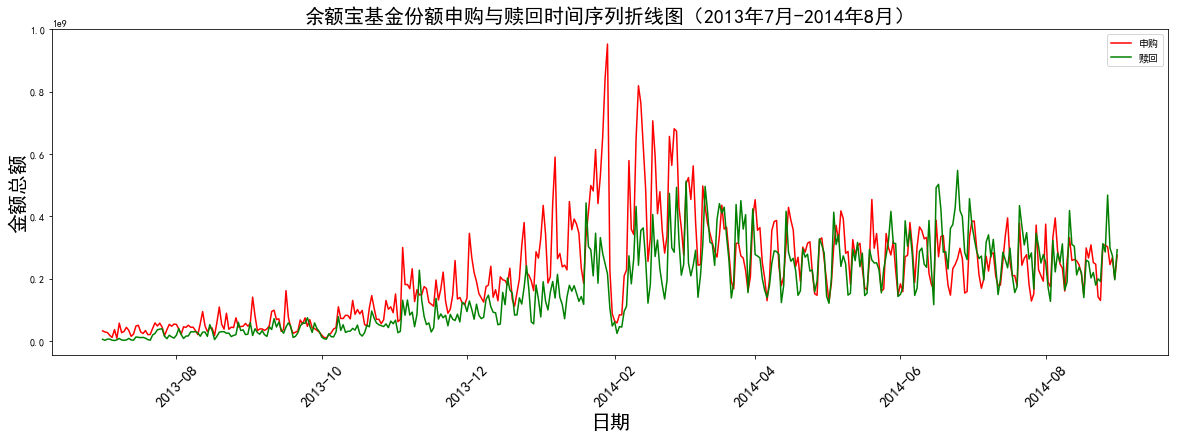

In [11]:
# 全局时序图
fig = plt.figure(figsize = (20, 6))
plt.plot(total_balance['Date'], total_balance['total_purchase_amt'], color = 'red', label = '申购')
plt.plot(total_balance['Date'], total_balance['total_redeem_amt'], color = 'green', label = '赎回')

plt.xticks(fontsize = 15, rotation = 45)

plt.title('余额宝基金份额申购与赎回时间序列折线图（2013年7月-2014年8月）', fontsize = 20)
plt.xlabel('日期', fontsize = 20)
plt.ylabel('金额总额', fontsize = 20)
plt.legend(loc = 'best')


plt.show()

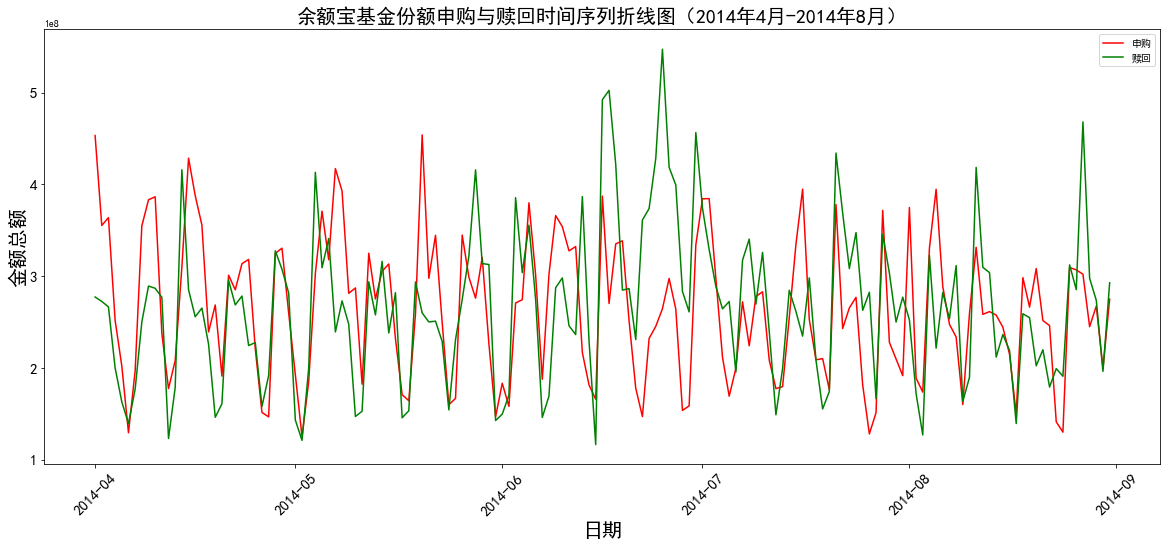

In [12]:
# 看出在14年4月之后，申购与赎回份额周期性特征更显著
# 因此作14年4月之后的时序折线图
sub_balance = total_balance[total_balance['Date'] >= pd.to_datetime('20140401')]

fig = plt.figure(figsize = (20, 8))
plt.plot(sub_balance['Date'], sub_balance['total_purchase_amt'], color = 'red', label = '申购')
plt.plot(sub_balance['Date'], sub_balance['total_redeem_amt'], color = 'green', label = '赎回')

plt.xticks(fontsize = 15, rotation = 45)
plt.yticks(fontsize = 15)

plt.title('余额宝基金份额申购与赎回时间序列折线图（2014年4月-2014年8月）', fontsize = 20)
plt.xlabel('日期', fontsize = 20)
plt.ylabel('金额总额', fontsize = 20)
plt.legend(loc = 'best')


plt.show()



可以看出，2014年4月之后，基本每个月有4个明显周期性，因此申购与赎回的时间序列大体为每星期一周期。

对2014年4月之后的5个月，分别绘制申购与赎回总量的折线图，如下：

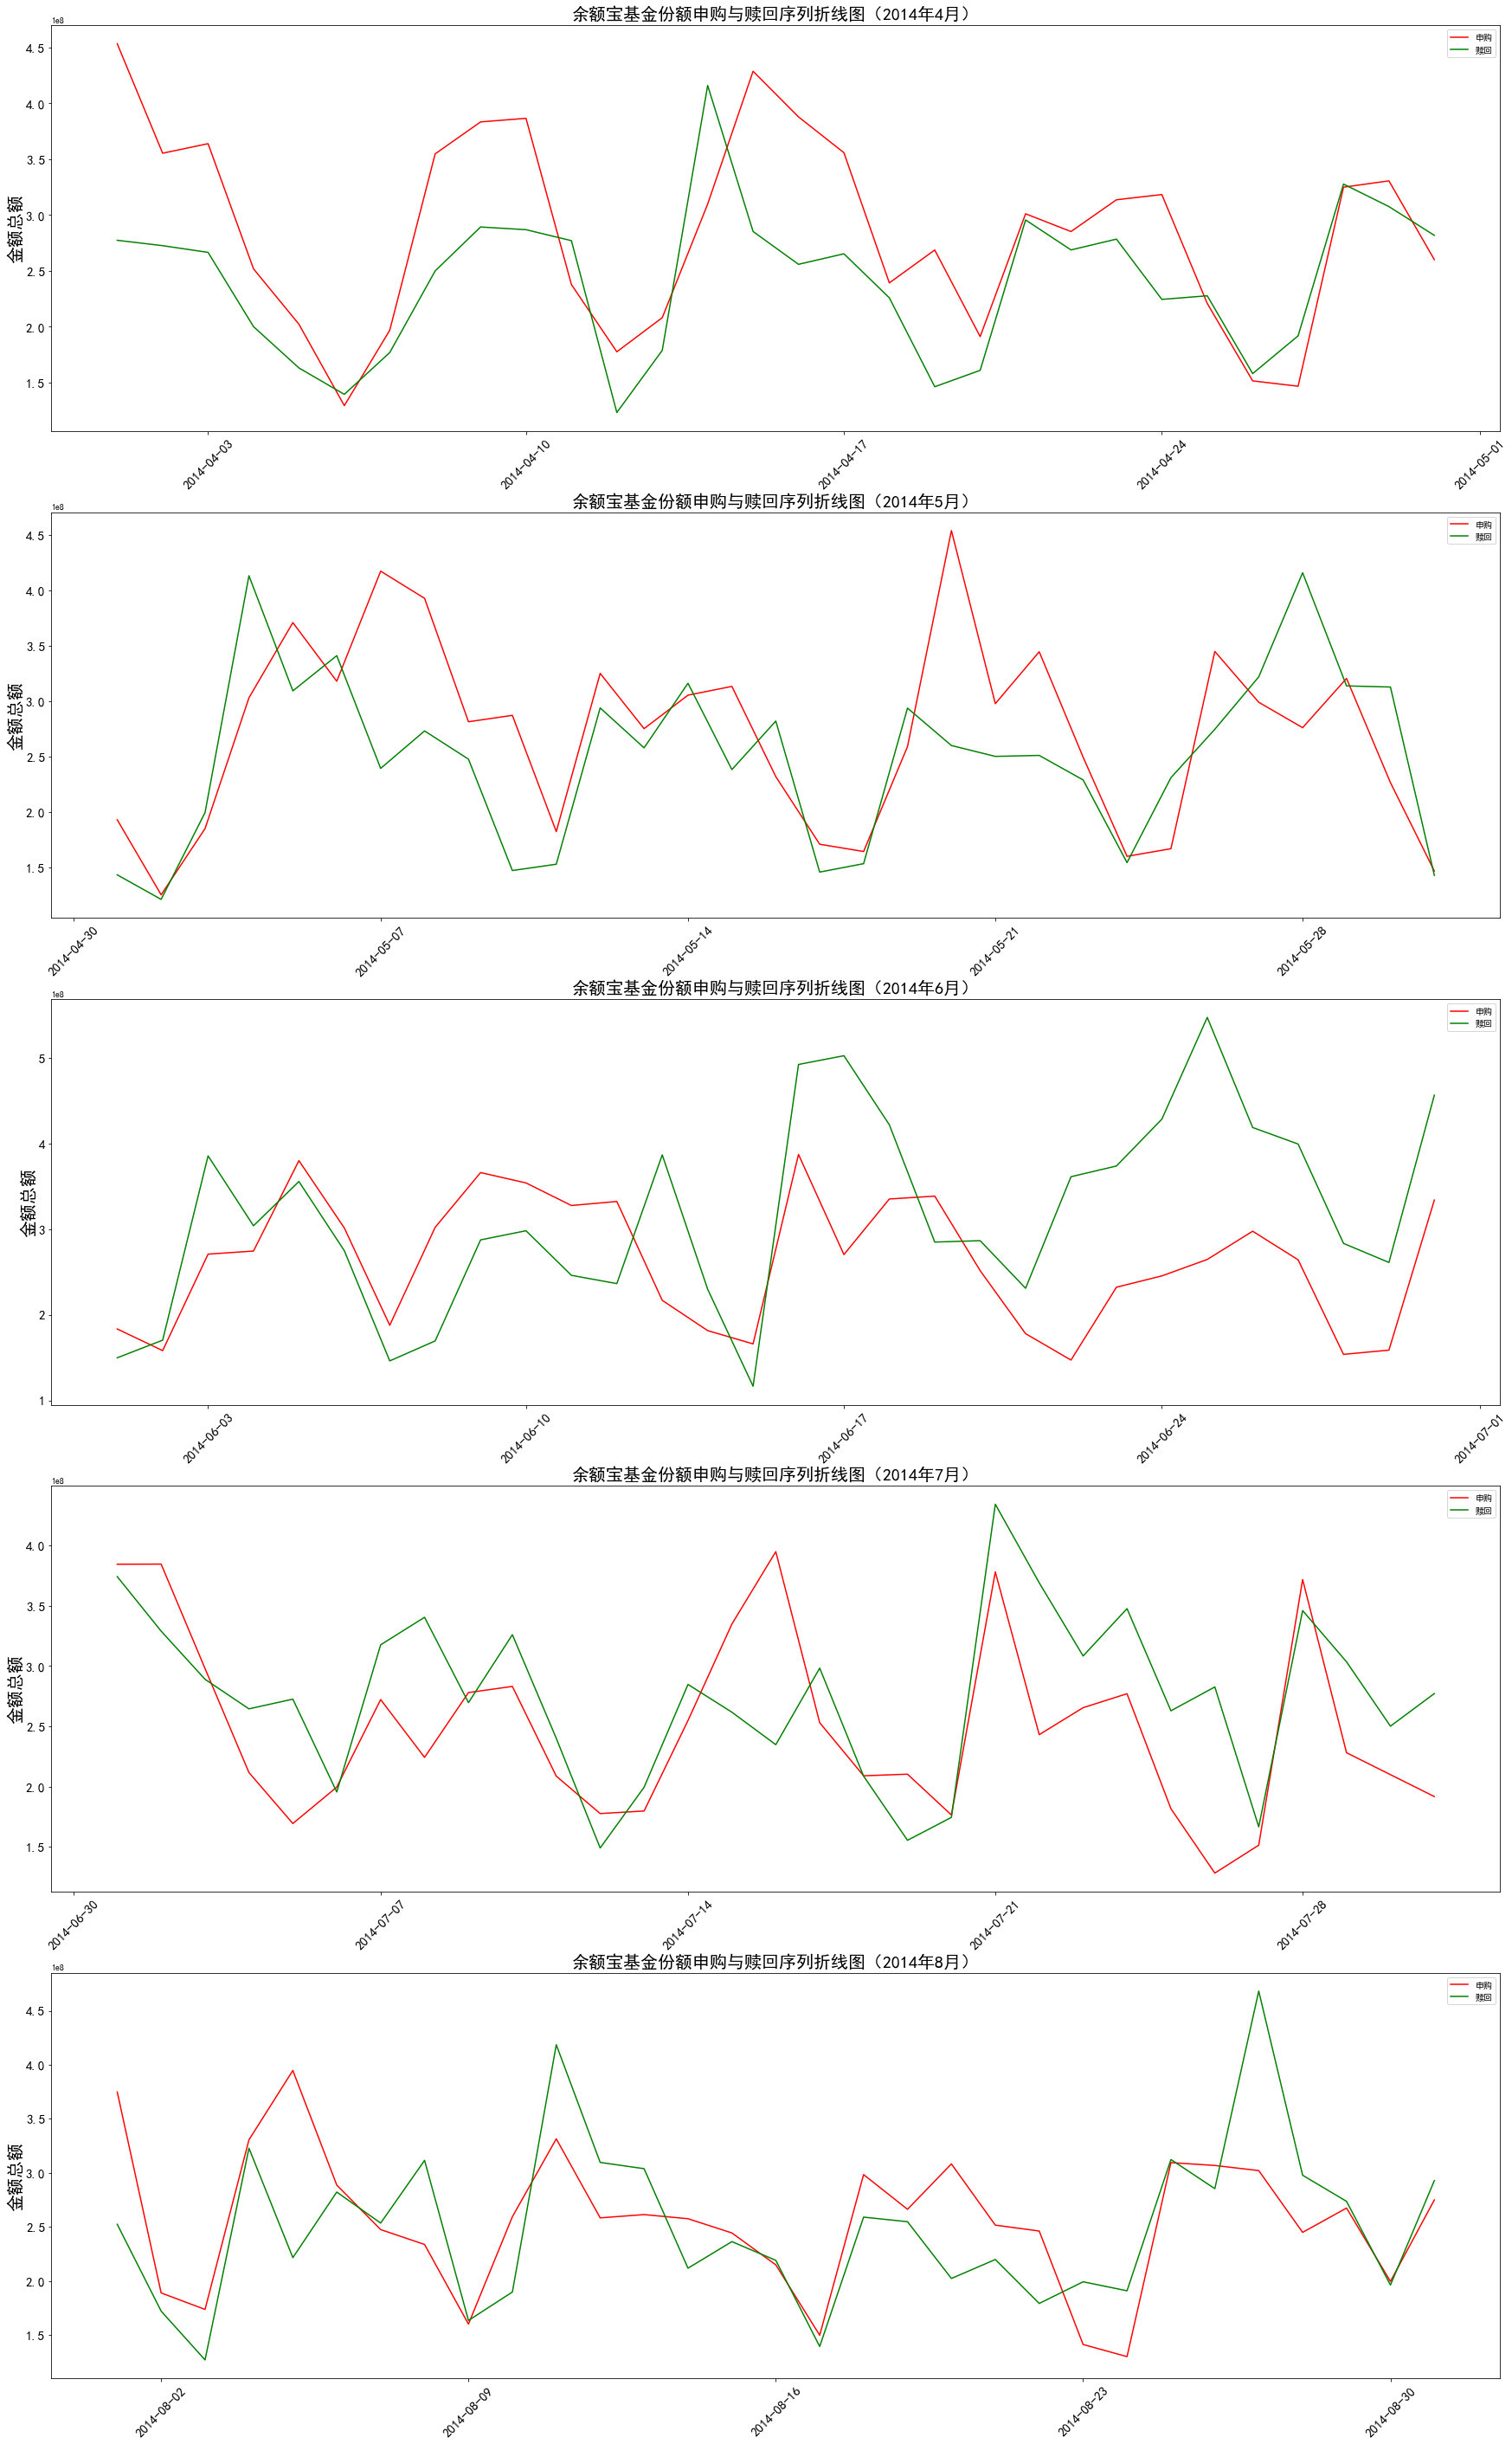

In [13]:
fig = plt.figure(figsize = (30, 50))

for ax in [1, 2, 3, 4, 5]:
    fig.add_subplot(5, 1, ax)
    month = 3 + ax
    sub_balance = total_balance[total_balance['Date'] >= pd.to_datetime('20140{:d}01'.format(month))]
    sub_balance = sub_balance[sub_balance['Date'] < pd.to_datetime('20140{:d}01'.format(month+1))]
    plt.plot(sub_balance['Date'], sub_balance['total_purchase_amt'], color = 'red', label = '申购')
    plt.plot(sub_balance['Date'], sub_balance['total_redeem_amt'], color = 'green', label = '赎回')
    plt.xticks(fontsize = 15, rotation = 45)
    plt.yticks(fontsize = 15)
    
    plt.title('余额宝基金份额申购与赎回序列折线图（2014年{:d}月）'.format(month), fontsize = 20)
    #plt.xlabel('日期', fontsize = 20)
    plt.ylabel('金额总额', fontsize = 20)
    plt.legend(loc = 'best')
    

## Step 4:分布性分析

In [14]:
# 为申购与赎回聚合后的数据集添加时间戳搜因

total_balance['Day'] = total_balance['Date'].dt.day
total_balance['Month'] = total_balance['Date'].dt.month
total_balance['Year'] = total_balance['Date'].dt.year
total_balance['Week'] = total_balance['Date'].dt.week
total_balance['Weekday'] = total_balance['Date'].dt.weekday

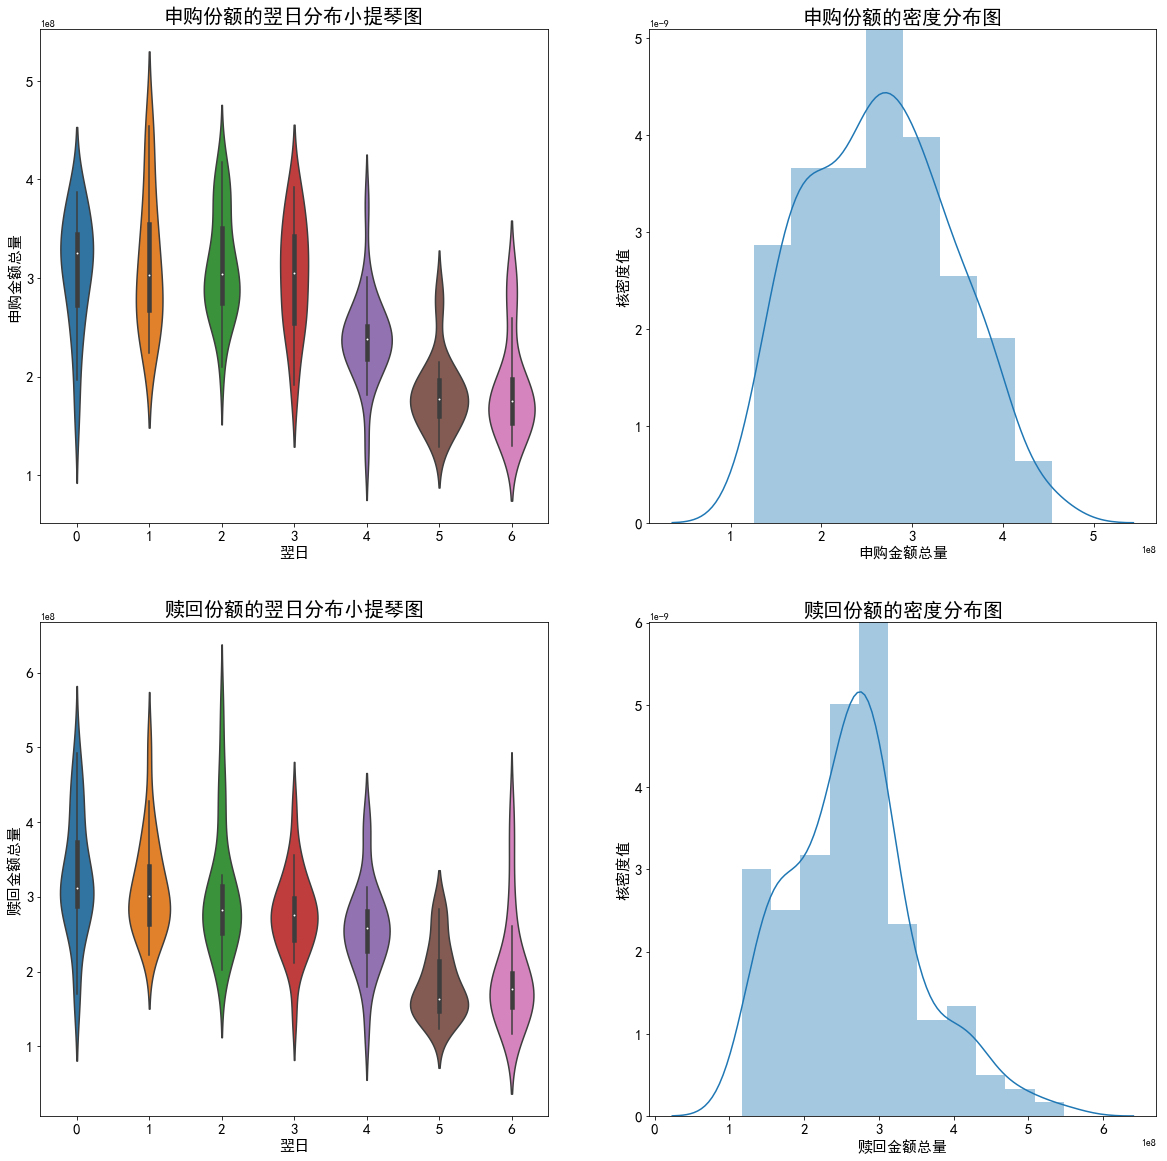

In [15]:
sub_balance = total_balance[total_balance['Date'] >= pd.to_datetime('20140401')]

scatter_para = {'marker':'.', 's':3, 'alpha':0.3}
line_kws = {'color':'k'}

fig = plt.figure(figsize = (20, 20))
# 申购份额的翌日分布的小提琴图
plt.subplot(2, 2, 1)
plt.title('申购份额的翌日分布小提琴图', fontsize = 20)
sns.violinplot(x = 'Weekday', y = 'total_purchase_amt', data = sub_balance, scatter_kws = scatter_para, line_kws = line_kws)
plt.xlabel('翌日', fontsize = 15)
plt.ylabel('申购金额总量', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

# 申购份额的密度分布图
plt.subplot(2, 2, 2)
plt.title('申购份额的密度分布图', fontsize = 20)
sns.distplot(sub_balance['total_purchase_amt'].dropna())
plt.xlabel('申购金额总量', fontsize = 15)
plt.ylabel('核密度值', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

# 赎回份额的翌日分布的小提琴图
plt.subplot(2, 2, 3)
plt.title('赎回份额的翌日分布小提琴图', fontsize = 20)
sns.violinplot(x = 'Weekday', y = 'total_redeem_amt', data = sub_balance, scatter_kws = scatter_para, line_kws = line_kws)
plt.xlabel('翌日', fontsize = 15)
plt.ylabel('赎回金额总量', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

# 赎回份额的密度分布图
plt.subplot(2, 2, 4)
plt.title('赎回份额的密度分布图', fontsize = 20)
sns.distplot(sub_balance['total_redeem_amt'].dropna())
plt.xlabel('赎回金额总量', fontsize = 15)
plt.ylabel('核密度值', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.show()


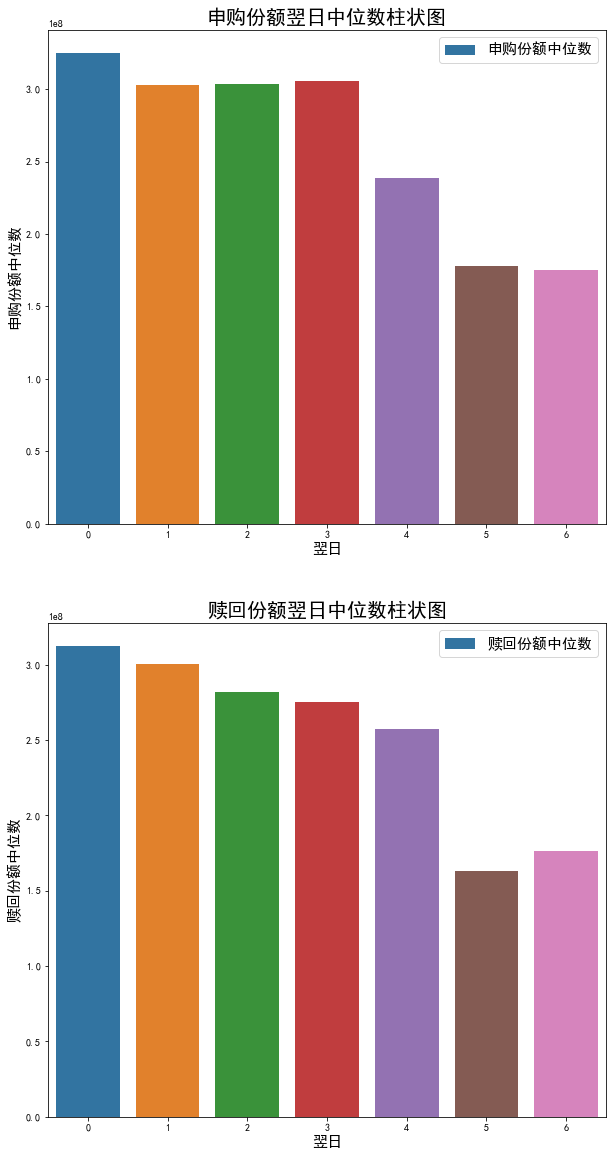

In [16]:
# 对每个翌日计算中位数后，绘制柱状图

# 运用聚合方法，对每个翌日求申购与赎回中位数
sub_balance_med = sub_balance[['Weekday', 
                               'total_purchase_amt', 
                               'total_redeem_amt']
                             ].groupby(by = 'Weekday', 
                                       as_index = False
                                      ).median()

# 分别绘制申购份额与赎回份额每个翌日中位数的柱状图
fig = plt.figure(figsize = (10, 20))

plt.subplot(2, 1, 1)
plt.title('申购份额翌日中位数柱状图', fontsize = 20)
ax = sns.barplot(x = 'Weekday', y = 'total_purchase_amt', data = sub_balance_med, label = '申购份额中位数')
ax.set_xlabel('翌日', fontsize = 15)
ax.set_ylabel('申购份额中位数', fontsize = 15)
ax.legend(fontsize = 15)

plt.subplot(2, 1, 2)
plt.title('赎回份额翌日中位数柱状图', fontsize = 20)
ax = sns.barplot(x = 'Weekday', y = 'total_redeem_amt', data = sub_balance_med, label = '赎回份额中位数')
ax.set_xlabel('翌日', fontsize = 15)
ax.set_ylabel('赎回份额中位数', fontsize = 15)
ax.legend(fontsize = 15)

plt.show()


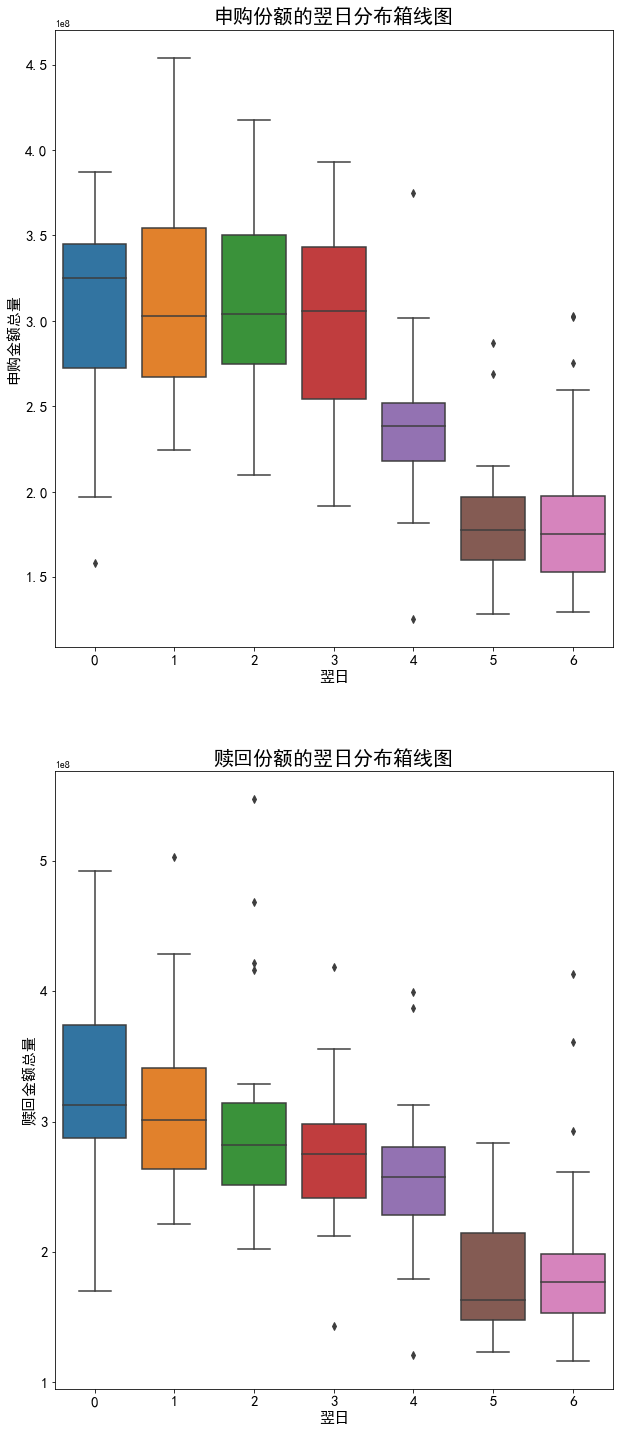

In [17]:
fig = plt.figure(figsize = (10, 25))
# 申购与赎回份额的翌日分布的箱线图

plt.subplot(2, 1, 1)
plt.title('申购份额的翌日分布箱线图', fontsize = 20)
sns.boxplot(x = 'Weekday', y = 'total_purchase_amt', data = sub_balance)
plt.xlabel('翌日', fontsize = 15)
plt.ylabel('申购金额总量', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.subplot(2, 1, 2)
plt.title('赎回份额的翌日分布箱线图', fontsize = 20)
sns.boxplot(x = 'Weekday', y = 'total_redeem_amt', data = sub_balance)
plt.xlabel('翌日', fontsize = 15)
plt.ylabel('赎回金额总量', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.show()

构造变量，分析与申购总量和赎回总量间相关性

In [18]:
# sklearn中OneHotEncoder模块下的格式要求
np.array(total_balance['Weekday']).reshape(-1, 1)[:10]

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [0],
       [1],
       [2]], dtype=int64)

In [19]:
encoder = OneHotEncoder()
week_feature = encoder.fit_transform(np.array(total_balance['Weekday']).reshape(-1, 1)).toarray()
week_feature[:10]

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]])

In [20]:
week_feature = pd.DataFrame(week_feature, columns = ['weekday_onehot'] * len(week_feature[0]))
feature = pd.concat([total_balance, week_feature], axis = 1)[['total_purchase_amt','total_redeem_amt','weekday_onehot','Date']]
feature.columns = list(feature.columns[0:2]) + [x+str(i) for i,x in enumerate(feature.columns[2:-1])] + ['date']

In [21]:
feature.head()

,total_purchase_amt,total_redeem_amt,weekday_onehot0,weekday_onehot1,weekday_onehot2,weekday_onehot3,weekday_onehot4,weekday_onehot5,weekday_onehot6,date
0,32488348,5525022,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2013-07-01
1,29037390,2554548,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2013-07-02
2,27270770,5953867,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2013-07-03
3,18321185,6410729,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2013-07-04
4,11648749,2763587,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2013-07-05


In [22]:
# 计算相关系数
Corr_pur_pd = feature[[x for x in feature.columns if x not in ['total_redeem_amt', 'date'] ]].corr('spearman')
Corr_red_pd = feature[[x for x in feature.columns if x not in ['total_purchase_amt', 'date'] ]].corr('spearman')

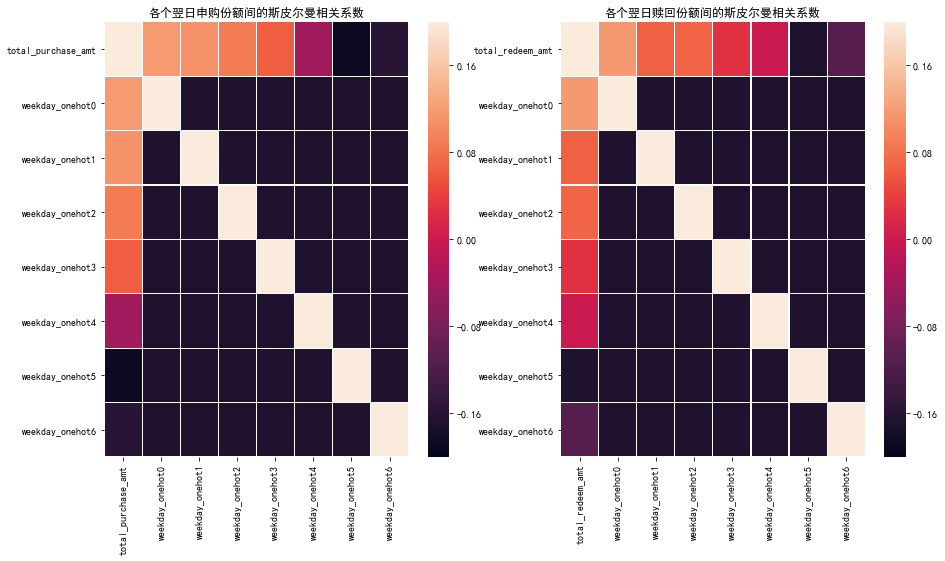

In [23]:
# 带有翌日的独立编码后，绘制相关系数热力图
f, ax = plt.subplots(figsize = (15, 8))
plt.subplot(1, 2, 1)
plt.title('各个翌日申购份额间的斯皮尔曼相关系数')
sns.heatmap(Corr_pur_pd, linewidths = 0.1, vmax = 0.2, vmin = -0.2)

plt.subplot(1, 2, 2)
plt.title('各个翌日赎回份额间的斯皮尔曼相关系数')
sns.heatmap(Corr_red_pd, linewidths = 0.1, vmax = 0.2, vmin = -0.2)

plt.show()

申购份额和赎回份额与星期几线性相关性较弱

In [24]:
feature[[x for x in feature.columns if x not in ['total_redeem_amt', 'date'] ]].corr('spearman')

,total_purchase_amt,weekday_onehot0,weekday_onehot1,weekday_onehot2,weekday_onehot3,weekday_onehot4,weekday_onehot5,weekday_onehot6
total_purchase_amt,1.000000,0.117820,0.109893,0.090129,0.065317,-0.040341,-0.186014,-0.156803
weekday_onehot0,0.117820,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667
weekday_onehot1,0.109893,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667
weekday_onehot2,0.090129,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667
weekday_onehot3,0.065317,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667
weekday_onehot4,-0.040341,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.166667
weekday_onehot5,-0.186014,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.166667
weekday_onehot6,-0.156803,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,1.000000


In [25]:
# 分析与申购总量和赎回总量间独立性
mv = mvtest()
print(mv.test(sub_balance['total_purchase_amt'], sub_balance['Weekday']))
print(mv.test(sub_balance['total_redeem_amt'], sub_balance['Weekday']))

{'Tn': 9.29, 'p-value': [0, 0.01]}
{'Tn': 7.35, 'p-value': [0, 0.01]}


P-val<0.05，说明申购总量和星期几，赎回总量和星期几是有依赖关系

## Step 5: 每月申购总额与赎回总额的分布特点

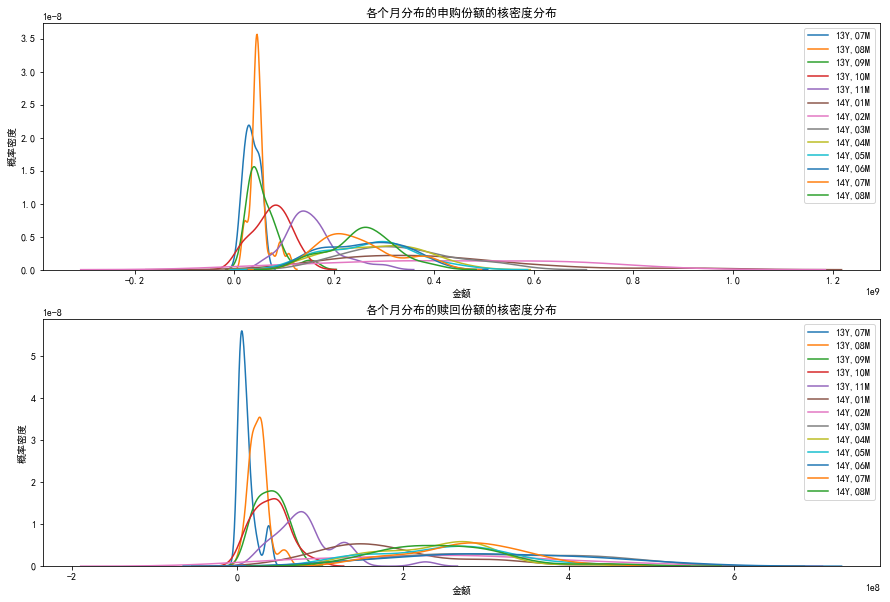

In [26]:
# 绘制每个月申购份额和赎回份额的的核密度分布图

plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.title('各个月分布的申购份额的核密度分布')
plt.ylabel('概率密度')
plt.xlabel('金额')

for i in range(7, 12):
    sub_info = total_balance[(total_balance['Date'] >= pd.to_datetime('2013{:02d}01'.format(i))) & (total_balance['Date'] < pd.to_datetime('2013{:02d}01'.format(i+1)))]
    sns.kdeplot(sub_info['total_purchase_amt'],label='13Y,{:02d}M'.format(i))
for i in range(1, 9):
    sub_info = total_balance[(total_balance['Date'] >= pd.to_datetime('2014{:02d}01'.format(i))) & (total_balance['Date'] < pd.to_datetime('2014{:02d}01'.format(i+1)))]    
    sns.kdeplot(sub_info['total_purchase_amt'],label='14Y,{:02d}M'.format(i))
    
plt.subplot(2,1,2)
plt.title('各个月分布的赎回份额的核密度分布')
plt.ylabel('概率密度')
plt.xlabel('金额')

for i in range(7, 12):
    sub_info = total_balance[(total_balance['Date'] >= pd.to_datetime('2013{:02d}01'.format(i))) & (total_balance['Date'] < pd.to_datetime('2013{:02d}01'.format(i+1)))]
    sns.kdeplot(sub_info['total_redeem_amt'],label='13Y,{:02d}M'.format(i))
for i in range(1, 9):
    sub_info = total_balance[(total_balance['Date'] >= pd.to_datetime('2014{:02d}01'.format(i))) & (total_balance['Date'] < pd.to_datetime('2014{:02d}01'.format(i+1)))]    
    sns.kdeplot(sub_info['total_redeem_amt'],label='14Y,{:02d}M'.format(i))

13年的7-10月的分布有明显差异

14年5-8月的申购赎回分布

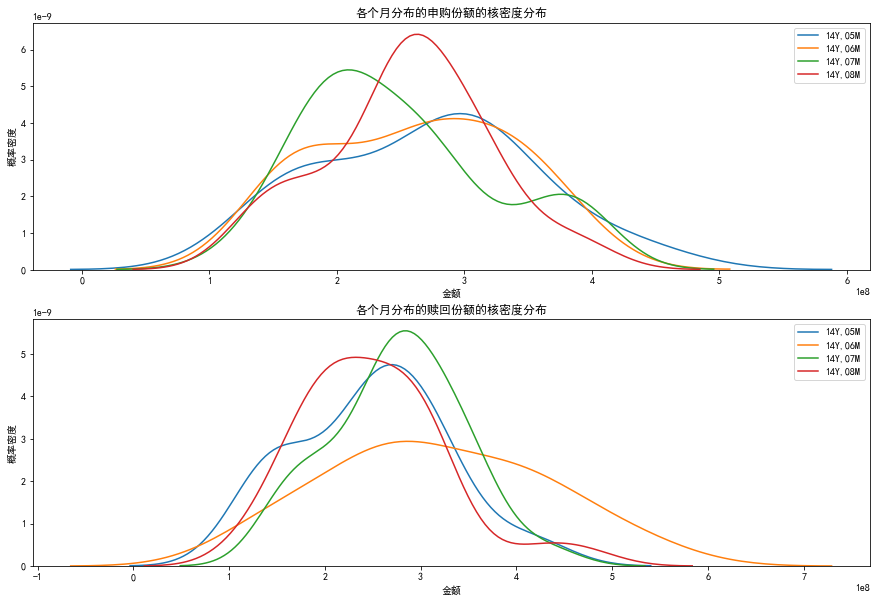

In [27]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.title('各个月分布的申购份额的核密度分布')
plt.ylabel('概率密度')
plt.xlabel('金额')

for i in range(5, 9):
    sub_info = total_balance[(total_balance['Date'] >= pd.to_datetime('2014{:02d}01'.format(i))) & (total_balance['Date'] < pd.to_datetime('2014{:02d}01'.format(i+1)))]    
    sns.kdeplot(sub_info['total_purchase_amt'],label='14Y,{:02d}M'.format(i))
    
plt.subplot(2,1,2)
plt.title('各个月分布的赎回份额的核密度分布')
plt.ylabel('概率密度')
plt.xlabel('金额')

for i in range(5, 9):
    sub_info = total_balance[(total_balance['Date'] >= pd.to_datetime('2014{:02d}01'.format(i))) & (total_balance['Date'] < pd.to_datetime('2014{:02d}01'.format(i+1)))]    
    sns.kdeplot(sub_info['total_redeem_amt'],label='14Y,{:02d}M'.format(i))

对于14年5-8月的申购份额，5月和6月分布类似，而7月和8月差异较大；

对于14年5-8月的赎回份额，5月和7月类似

13年7-10月的申购赎回分布

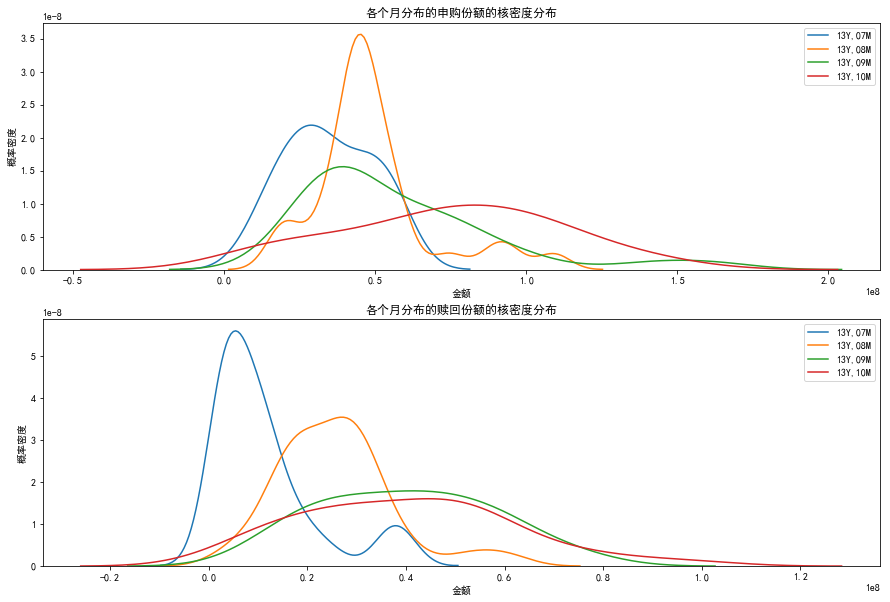

In [28]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.title('各个月分布的申购份额的核密度分布')
plt.ylabel('概率密度')
plt.xlabel('金额')

for i in range(7, 11):
    sub_info = total_balance[(total_balance['Date'] >= pd.to_datetime('2013{:02d}01'.format(i))) & (total_balance['Date'] < pd.to_datetime('2013{:02d}01'.format(i+1)))]    
    sns.kdeplot(sub_info['total_purchase_amt'],label='13Y,{:02d}M'.format(i))
    
plt.subplot(2,1,2)
plt.title('各个月分布的赎回份额的核密度分布')
plt.ylabel('概率密度')
plt.xlabel('金额')

for i in range(7, 11):
    sub_info = total_balance[(total_balance['Date'] >= pd.to_datetime('2013{:02d}01'.format(i))) & (total_balance['Date'] < pd.to_datetime('2013{:02d}01'.format(i+1)))]    
    sns.kdeplot(sub_info['total_redeem_amt'],label='13Y,{:02d}M'.format(i))

9月和8月差异较大

而9月和10月分布类似

## Step 6: 按天可视化申购总额与赎回总额的分布特点

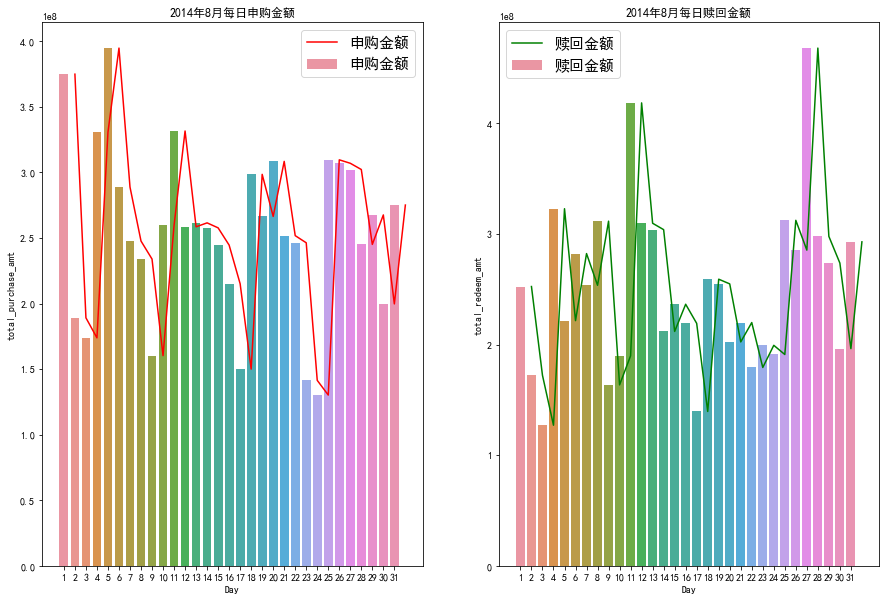

In [29]:
# 利用直方图来分析14年8月份申购和赎回总额
sub_info = total_balance[(total_balance['Date'] >= pd.to_datetime('20140801')) & (total_balance['Date'] < pd.to_datetime('20140901'))]

plt.figure(figsize = (15, 10))

plt.subplot(1, 2, 1)
ax = sns.barplot(x = 'Day', y = 'total_purchase_amt', data = sub_info, label = '申购金额')
ax = sns.lineplot(x = 'Day', y = 'total_purchase_amt', data = sub_info, label = '申购金额', color = 'red')

ax.legend(fontsize = 15)
ax.set_title('2014年8月每日申购金额')

plt.subplot(1, 2, 2)
ax = sns.barplot(x = 'Day', y = 'total_redeem_amt', data = sub_info, label = '赎回金额')
ax = sns.lineplot(x = 'Day', y = 'total_redeem_amt', data = sub_info, label = '赎回金额', color = 'green')

ax.legend(fontsize = 15)
ax.set_title('2014年8月每日赎回金额')

plt.show()

2014年8月1日为周五看，4日为周一，每周为周期看

一周内申购金额周一周二高然后后面回落

一周内工作日前几日内赎回金额较高，周末有一定回落

In [30]:
total_balance.head()

,Date,total_purchase_amt,total_redeem_amt,Day,Month,Year,Week,Weekday
0,2013-07-01,32488348,5525022,1,7,2013,27,0
1,2013-07-02,29037390,2554548,2,7,2013,27,1
2,2013-07-03,27270770,5953867,3,7,2013,27,2
3,2013-07-04,18321185,6410729,4,7,2013,27,3
4,2013-07-05,11648749,2763587,5,7,2013,27,4


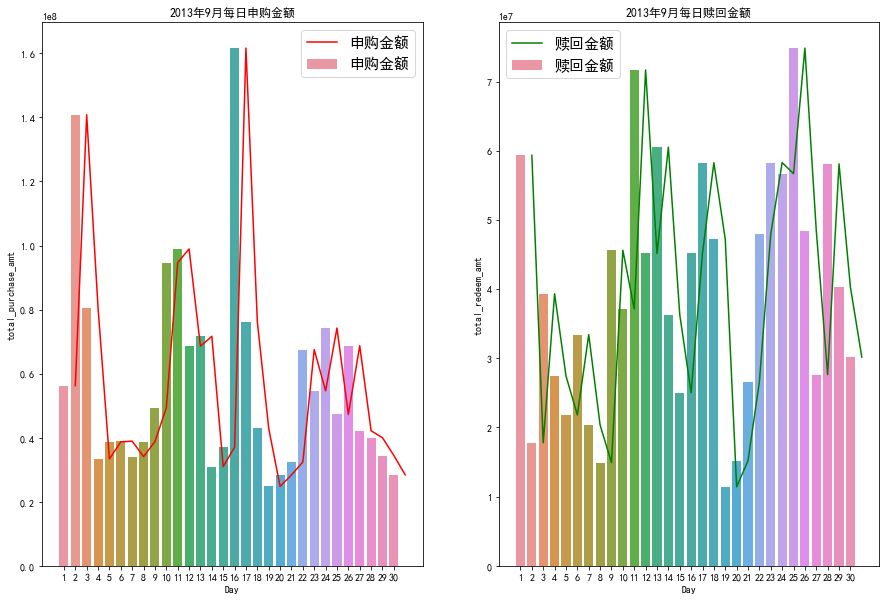

In [31]:
# 利用直方图来分析13年9月份申购和赎回总额
sub_info = total_balance[(total_balance['Date'] >= pd.to_datetime('20130901')) & (total_balance['Date'] < pd.to_datetime('20131001'))]

plt.figure(figsize = (15, 10))

plt.subplot(1, 2, 1)
ax = sns.barplot(x = 'Day', y = 'total_purchase_amt', data = sub_info, label = '申购金额')
ax = sns.lineplot(x = 'Day', y = 'total_purchase_amt', data = sub_info, label = '申购金额', color = 'red')

ax.legend(fontsize = 15)
ax.set_title('2013年9月每日申购金额')

plt.subplot(1, 2, 2)
ax = sns.barplot(x = 'Day', y = 'total_redeem_amt', data = sub_info, label = '赎回金额')
ax = sns.lineplot(x = 'Day', y = 'total_redeem_amt', data = sub_info, label = '赎回金额', color = 'green')

ax.legend(fontsize = 15)
ax.set_title('2013年9月每日赎回金额')

plt.show()

进一步看出，申购峰值为16日（中秋节前）

赎回峰值为28日（国庆节前），11日，25日（周三）

交易低谷期19-21日为中秋节，29-30日国庆节

In [32]:
# 绘制热力图
# 初始化表，周数量为纵轴，横轴为翌日
pur_map = np.zeros((max(sub_balance['Week']) - min(sub_balance['Week']) + 1, 7))
red_map = np.zeros((max(sub_balance['Week']) - min(sub_balance['Week']) + 1, 7))

# 填充数值，申购与赎回
pur_map[sub_balance['Week'] - min(sub_balance['Week']), sub_balance['Weekday']] = sub_balance['total_purchase_amt']
red_map[sub_balance['Week'] - min(sub_balance['Week']), sub_balance['Weekday']] = sub_balance['total_redeem_amt']

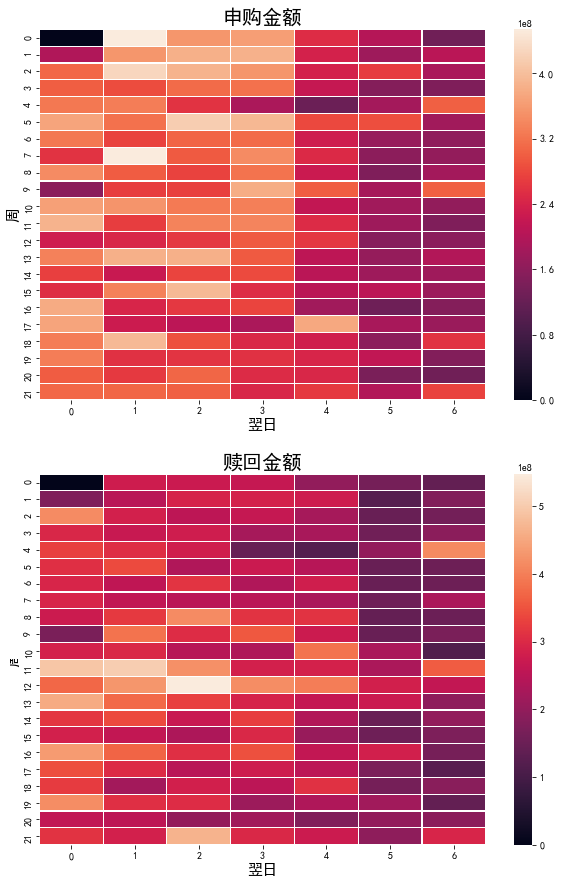

In [33]:
plt.figure(figsize = (10, 15))

plt.subplot(2, 1, 1)
ax = sns.heatmap(pur_map, linewidths = 0.1)
ax.set_title('申购金额', fontsize = 20)
ax.set_xlabel('翌日',fontsize = 15)
ax.set_ylabel('周', fontsize = 15)

plt.subplot(2, 1, 2)
ax = sns.heatmap(red_map, linewidths = 0.1)
ax.set_title('赎回金额', fontsize = 20)
ax.set_xlabel('翌日',fontsize = 15)
ax.set_ylabel('周', fontsize = 15)

plt.show()

## Step 7:分析节假日及特殊日期

In [34]:
# 获取节假日的数据

qingming = total_balance[(total_balance['Date'] >= pd.to_datetime('20140405')) & (total_balance['Date'] < pd.to_datetime('20140408'))]
labour = total_balance[(total_balance['Date'] >=pd.to_datetime('20140501')) & (total_balance['Date'] < pd.to_datetime('20140504'))]
duanwu = total_balance[(total_balance['Date'] >= pd.to_datetime('20140531')) & (total_balance['Date'] < pd.to_datetime('20140603'))]
data618 = total_balance[(total_balance['Date'] >= pd.to_datetime('20140610')) & (total_balance['Date'] < pd.to_datetime('20140620'))]

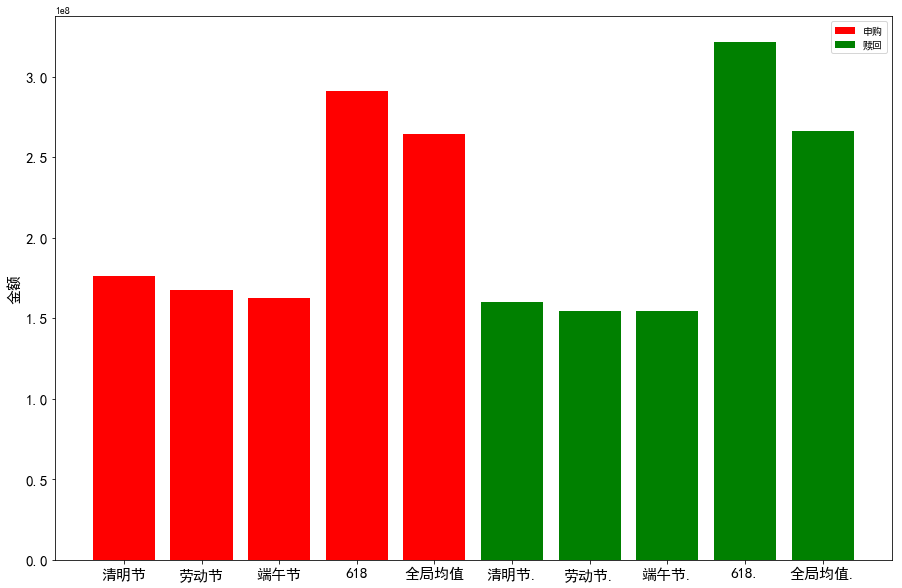

In [35]:
# 画出节假日与平时的均值

fig = plt.figure(figsize = (15, 10))
index_list = ['清明节','劳动节','端午节','618','全局均值']
label_list = [np.mean(qingming['total_purchase_amt']), 
              np.mean(labour['total_purchase_amt']),
              np.mean(duanwu['total_purchase_amt']),
              np.mean(data618['total_purchase_amt']),
              np.mean(sub_balance['total_purchase_amt'])]
plt.xticks(fontsize = 15)
plt.bar(index_list, label_list, color = 'red', label="申购")

index_list = ['清明节.','劳动节.','端午节.','618.','全局均值.']
label_list = [np.mean(qingming['total_redeem_amt']), 
              np.mean(labour['total_redeem_amt']),
              np.mean(duanwu['total_redeem_amt']),
              np.mean(data618['total_redeem_amt']),
              np.mean(sub_balance['total_redeem_amt'])]
plt.bar(index_list, label_list, color = 'green', label="赎回")
plt.xticks(fontsize = 15)

plt.yticks(fontsize = 15)
plt.ylabel("金额", fontsize = 15)
plt.legend(loc = 'best')
plt.show()

无论申购还是赎回，节假日的金额流量，远小于平均流量。

618天猫节流量略高于平均流量

In [36]:
qm_nor_pur = np.mean(sub_balance[sub_balance['Weekday'].apply(lambda x:x in qingming['Weekday'].values)]['total_purchase_amt'])
qm_nor_red = np.mean(sub_balance[sub_balance['Weekday'].apply(lambda x:x in qingming['Weekday'].values)]['total_redeem_amt'])

labour_nor_pur = np.mean(sub_balance[sub_balance['Weekday'].apply(lambda x:x in labour['Weekday'].values)]['total_purchase_amt'])
labour_nor_red = np.mean(sub_balance[sub_balance['Weekday'].apply(lambda x:x in labour['Weekday'].values)]['total_redeem_amt'])

dw_nor_pur = np.mean(sub_balance[sub_balance['Weekday'].apply(lambda x:x in duanwu['Weekday'].values)]['total_purchase_amt'])
dw_nor_red = np.mean(sub_balance[sub_balance['Weekday'].apply(lambda x:x in duanwu['Weekday'].values)]['total_redeem_amt'])

d618_nor_pur = np.mean(sub_balance[sub_balance['Weekday'].apply(lambda x:x in data618['Weekday'].values)]['total_purchase_amt'])
d618_nor_red = np.mean(sub_balance[sub_balance['Weekday'].apply(lambda x:x in data618['Weekday'].values)]['total_redeem_amt'])

nor_pur = [qm_nor_pur, labour_nor_pur, dw_nor_pur, d618_nor_pur]
nor_red = [qm_nor_red, labour_nor_red, dw_nor_red, d618_nor_red]

In [37]:
nor_pur,nor_red

([225337516.07692307,
  241859315.24242425,
  225337516.07692307,
  264316704.13071895],
 [235439685.04615384,
  240364238.87878788,
  235439685.04615384,
  266400750.50326797])

<Figure size 1080x1440 with 0 Axes>

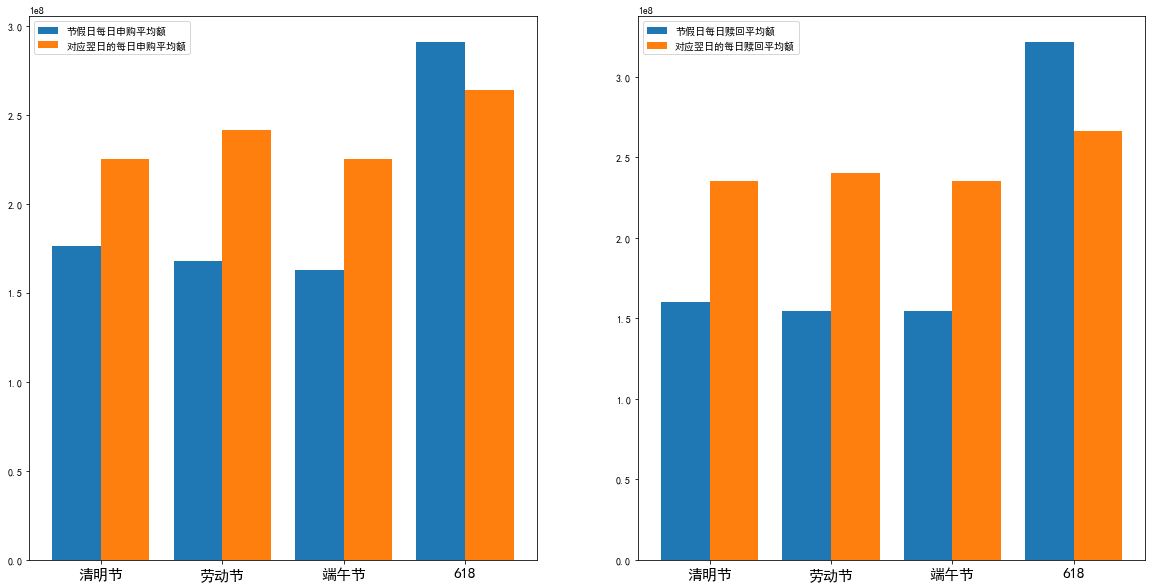

In [38]:
# 绘制双柱状图对比这些节日和平日对应翌日的流量

plt.figure(figsize = (15, 20))
size = 4
x = np.arange(size)

# 一个点的宽度和柱状图数量，在此为2个柱状图
total_width, n = 0.8, 2
width = total_width / n
x = x - width # 第一个柱状图的位置

# 申购金额对比
plt.figure(figsize = (20, 10))
plt.subplot(1, 2, 1)
plt.bar(x, [np.mean(qingming['total_purchase_amt']), 
            np.mean(labour['total_purchase_amt']), 
            np.mean(duanwu['total_purchase_amt']), 
            np.mean(data618['total_purchase_amt'])
           ], 
        width = width, 
        label = '节假日每日申购平均额')

plt.bar(x + width, nor_pur, width = width, label = '对应翌日的每日申购平均额')
plt.xticks(x + width / 2, ['清明节','劳动节','端午节','618'], fontsize = 15)
plt.legend()

# 赎回金额对比
plt.subplot(1, 2, 2)
plt.bar(x, [np.mean(qingming['total_redeem_amt']), 
            np.mean(labour['total_redeem_amt']), 
            np.mean(duanwu['total_redeem_amt']), 
            np.mean(data618['total_redeem_amt'])
           ], 
        width = width, 
        label = '节假日每日赎回平均额')

plt.bar(x + width, nor_red, width = width, label = '对应翌日的每日赎回平均额')
plt.xticks(x + width / 2, ['清明节','劳动节','端午节','618'], fontsize = 15)
plt.legend()



plt.show()

除了天猫618，其余节假日的流量，均低于平时对应翌日平均值

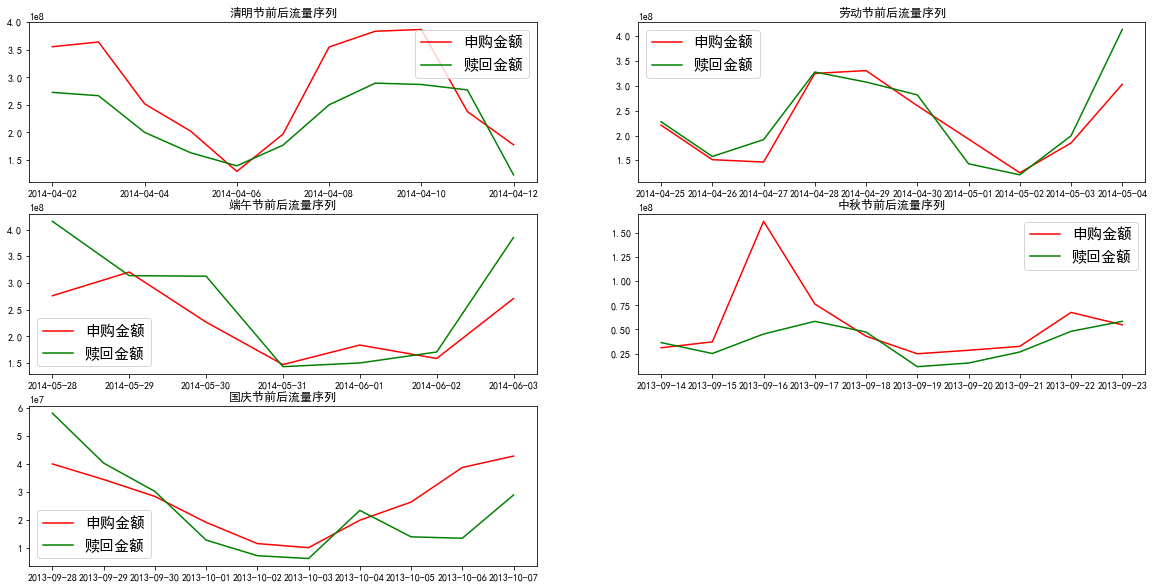

In [39]:
# 绘制时序图对节假日附近时间的流量分析
plt.figure(figsize = (20, 10))

# 清明节前后流量序列
plt.subplot(3, 2, 1)
sub_info = sub_balance[(sub_balance['Date'] >= pd.to_datetime('20140402')) & (sub_balance['Date'] < pd.to_datetime('20140413'))]
plt.plot(sub_info['Date'], sub_info['total_purchase_amt'], color = 'red', label = '申购金额')
plt.plot(sub_info['Date'], sub_info['total_redeem_amt'], color = 'green', label = '赎回金额')
plt.legend(fontsize = 15, loc = 'best')
plt.title('清明节前后流量序列')

# 劳动节前后流量序列
plt.subplot(3, 2, 2)
sub_info = sub_balance[(sub_balance['Date'] >= pd.to_datetime('20140425')) & (sub_balance['Date'] < pd.to_datetime('20140505'))]
plt.plot(sub_info['Date'], sub_info['total_purchase_amt'], color = 'red', label = '申购金额')
plt.plot(sub_info['Date'], sub_info['total_redeem_amt'], color = 'green', label = '赎回金额')
plt.legend(fontsize = 15, loc = 'best')
plt.title('劳动节前后流量序列')

# 端午节前后流量序列
plt.subplot(3, 2, 3)
sub_info = total_balance[(total_balance['Date'] >= pd.to_datetime('20140528')) & (total_balance['Date'] < pd.to_datetime('20140604'))]
plt.plot(sub_info['Date'], sub_info['total_purchase_amt'], color = 'red', label = '申购金额')
plt.plot(sub_info['Date'], sub_info['total_redeem_amt'], color = 'green', label = '赎回金额')
plt.legend(fontsize = 15, loc = 'best')
plt.title('端午节前后流量序列')

# 中秋节前后流量序列
plt.subplot(3, 2, 4)
sub_info = total_balance[(total_balance['Date'] >= pd.to_datetime('20130914')) & (total_balance['Date'] < pd.to_datetime('20130924'))]
plt.plot(sub_info['Date'], sub_info['total_purchase_amt'], color = 'red', label = '申购金额')
plt.plot(sub_info['Date'], sub_info['total_redeem_amt'], color = 'green', label = '赎回金额')
plt.legend(fontsize = 15, loc = 'best')
plt.title('中秋节前后流量序列')

# 国庆节前后流量序列
plt.subplot(3, 2, 5)
sub_info = total_balance[(total_balance['Date'] >= pd.to_datetime('20130928')) & (total_balance['Date'] < pd.to_datetime('20131008'))]
plt.plot(sub_info['Date'], sub_info['total_purchase_amt'], color = 'red', label = '申购金额')
plt.plot(sub_info['Date'], sub_info['total_redeem_amt'], color = 'green', label = '赎回金额')
plt.legend(fontsize = 15, loc = 'best')
plt.title('国庆节前后流量序列')

plt.show()

## Step 8：分析大额交易

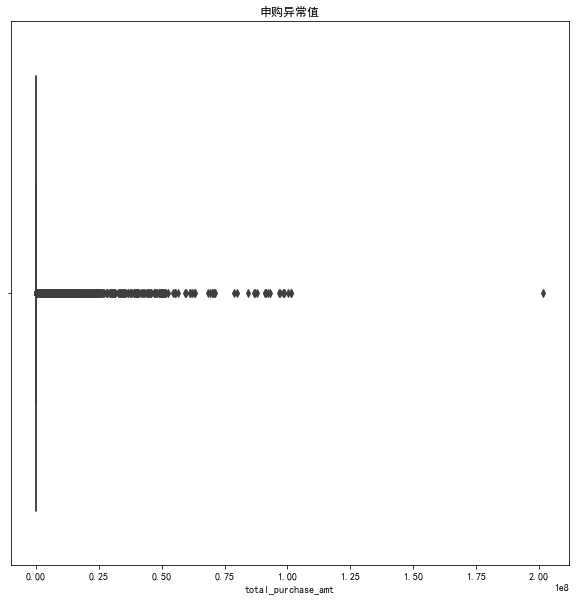

In [40]:
# 画出用户交易纪录的箱型图

plt.figure(figsize = (10, 10))
sns.boxplot(data_balance['total_purchase_amt'])
plt.title("申购异常值")

plt.show()

In [41]:
# 找到有异常申购份额的用户id，获取该用户id的记录
abn_id = data_balance[data_balance['total_purchase_amt'] >= 2e8]['user_id'].values[0]
abn_date = str(data_balance[data_balance['total_purchase_amt'] >= 2e8]['report_date'].values[0])
print(abn_id, abn_date)
user_info = data_balance[data_balance['user_id'] == abn_id]

14592 20131104


In [42]:
user_info.head()

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,...,category1,category2,category3,category4,Date,Day,Month,Year,Week,Weekday
1453208,14592,20140503,374435,374385,50,0,0,0,0,0,...,NaN,NaN,NaN,NaN,2014-05-03,3,5,2014,18,5
1453209,14592,20140428,374185,374135,50,0,0,0,0,0,...,NaN,NaN,NaN,NaN,2014-04-28,28,4,2014,18,0
1453210,14592,20131106,97662610,97458675,203935,191347,0,191347,0,0,...,NaN,NaN,NaN,NaN,2013-11-06,6,11,2013,45,2
1453211,14592,20131109,97700425,97687834,12591,0,0,0,0,0,...,NaN,NaN,NaN,NaN,2013-11-09,9,11,2013,45,5
1453212,14592,20131112,97697850,97683611,14239,0,0,0,0,0,...,NaN,NaN,NaN,NaN,2013-11-12,12,11,2013,46,1


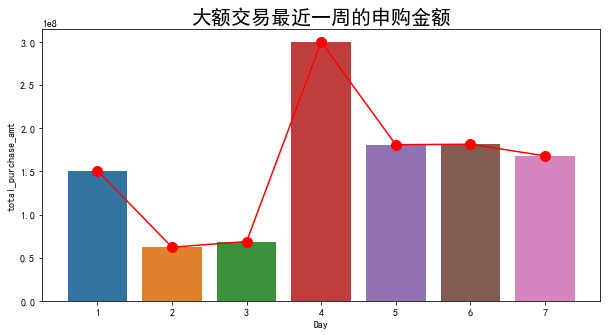

In [43]:
# 绘制大额交易所最近一周的申购情况柱状图
sub_info = total_balance[((total_balance['Date'] - pd.to_datetime(abn_date)) <= pd.Timedelta(days = 3)) & ((total_balance['Date'] - pd.to_datetime(abn_date)) >= pd.Timedelta(days = -3))]

plt.figure(figsize = (10, 5))
sns.barplot(x = 'Day', y = 'total_purchase_amt', data = sub_info)
plt.plot(sub_info['Day'] - 1, sub_info['total_purchase_amt'], marker = '.', markersize = 20, color = 'red')
plt.title('大额交易最近一周的申购金额',fontsize = 20)

plt.show()

In [44]:
sub_info

,Date,total_purchase_amt,total_redeem_amt,Day,Month,Year,Week,Weekday
123,2013-11-01,150904945,66933119,1,11,2013,44,4
124,2013-11-02,62132300,26705506,2,11,2013,44,5
125,2013-11-03,68707870,30895754,3,11,2013,44,6
126,2013-11-04,300027403,130970051,4,11,2013,45,0
127,2013-11-05,180904814,82689864,5,11,2013,45,1
128,2013-11-06,181474910,131707820,6,11,2013,45,2
129,2013-11-07,167963464,83306452,7,11,2013,45,3


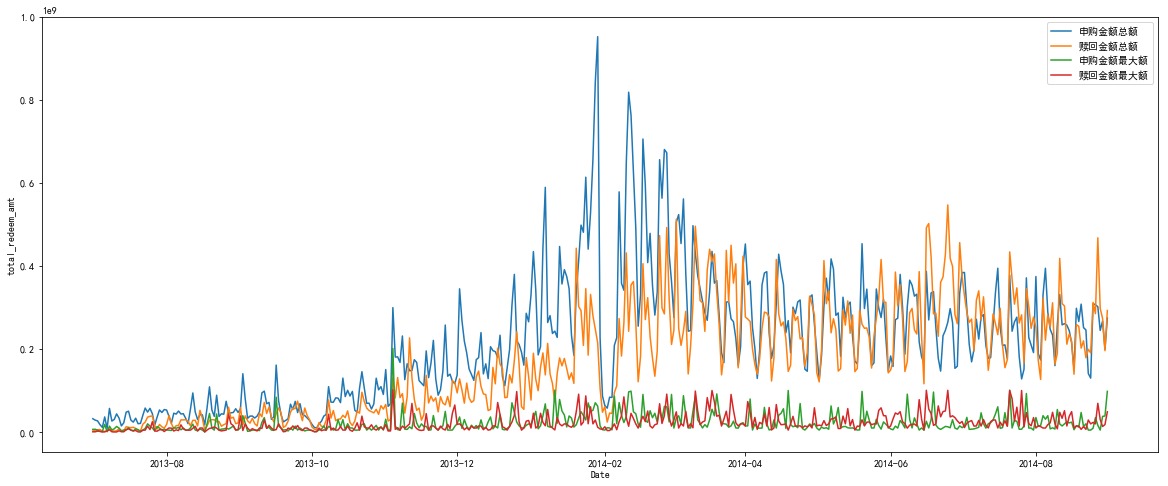

In [54]:
# 绘制每日最大交易额的时序图
max_flow = data_balance[['Date','total_purchase_amt','total_redeem_amt']].groupby(by = 'Date', as_index = False).max()

plt.figure(figsize = (20, 8))
sns.lineplot(x = 'Date', y = 'total_purchase_amt', data = total_balance, label = '申购金额总额')
sns.lineplot(x = 'Date', y = 'total_redeem_amt', data = total_balance, label = '赎回金额总额')

sns.lineplot(x = 'Date', y = 'total_purchase_amt', data = max_flow, label = '申购金额最大额')
sns.lineplot(x = 'Date', y = 'total_redeem_amt', data = max_flow, label = '赎回金额最大额')

plt.show()

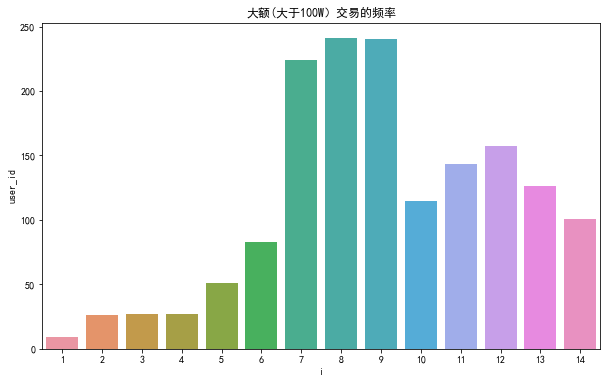

In [65]:
# 画出每个月大额交易的频次直方图
plt.figure(figsize = (10, 6))
big_frequancy = data_balance[(data_balance['total_purchase_amt'] > 10000000) | (data_balance['total_redeem_amt'] > 10000000)][['Month','Year','user_id']].groupby(['Year','Month'], as_index=False).count()
big_frequancy['i'] = (big_frequancy['Year'] - 2013) * 6 - (2014 - big_frequancy['Year']) * 6 + big_frequancy['Month']
ax = sns.barplot(x="i", y="user_id", data=big_frequancy)
plt.title("大额(大于100W）交易的频率")
plt.show()

In [80]:
# 识别大额交易和小额交易
data_balance['big_purchase'] = 0
data_balance.loc[data_balance['total_purchase_amt'] >= 1000000, 'big_purchase'] = 1

data_balance['big_redeem'] = 0
data_balance.loc[data_balance['total_redeem_amt'] >= 1000000, 'big_redeem'] = 1

In [82]:
data_balance[data_balance['total_purchase_amt'] >= 1000000].head()

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,...,category3,category4,Date,Day,Month,Year,Week,Weekday,big_purchase,big_redeem
694,23,20140310,8180394,2039651,6140743,6140437,6140437,0,0,0,...,NaN,NaN,2014-03-10,10,3,2014,11,0,1,0
707,23,20140222,2438652,0,3954226,3954226,3954226,0,1515574,0,...,NaN,NaN,2014-02-22,22,2,2014,8,5,1,1
714,23,20140315,12205439,7361649,4945548,4944458,4944458,0,101758,0,...,NaN,NaN,2014-03-15,15,3,2014,11,5,1,0
727,23,20140423,6132293,1460404,4671889,4671690,4671690,0,0,0,...,NaN,NaN,2014-04-23,23,4,2014,17,2,1,0
734,23,20140513,1694544,482734,1211810,1211748,1211748,0,0,0,...,NaN,NaN,2014-05-13,13,5,2014,20,1,1,0


In [84]:
# 对大额交易按每天做聚合操作

big_purchase = data_balance[data_balance['big_purchase'] == 1].groupby(['Date'], as_index=False)['total_purchase_amt'].sum()
small_purchase = data_balance[data_balance['big_purchase'] == 0].groupby(['Date'], as_index=False)['total_purchase_amt'].sum()
big_redeem = data_balance[data_balance['big_redeem'] == 1].groupby(['Date'], as_index=False)['total_redeem_amt'].sum()
small_redeem = data_balance[data_balance['big_redeem'] == 0].groupby(['Date'], as_index=False)['total_redeem_amt'].sum()

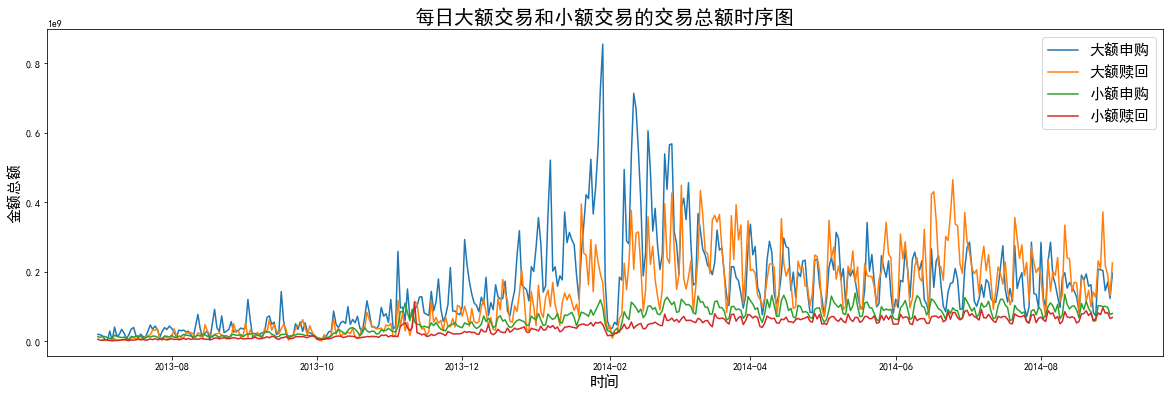

In [87]:
# 画出大额交易与小额交易的时序分布图

fig = plt.figure(figsize=(20,6))
plt.plot(big_purchase['Date'], big_purchase['total_purchase_amt'],label='大额申购')
plt.plot(big_redeem['Date'], big_redeem['total_redeem_amt'],label='大额赎回')

plt.plot(small_purchase['Date'], small_purchase['total_purchase_amt'],label='小额申购')
plt.plot(small_redeem['Date'], small_redeem['total_redeem_amt'],label='小额赎回')
plt.legend(loc='best', fontsize = 15)
plt.title("每日大额交易和小额交易的交易总额时序图",fontsize = 20)
plt.xlabel("时间",fontsize = 15)
plt.ylabel("金额总额", fontsize = 15)
plt.show()

## Step 9:分析银行拆解利率与余额宝利率

In [89]:
# 读取银行利率并添加时间戳索引

bank = bank.rename(columns = {'mfd_date': 'Date'})
bank_features = [x for x in bank.columns if x not in ['Date']]
bank['Date'] = pd.to_datetime(bank['Date'], format= "%Y%m%d")

bank['Day'] = bank['Date'].dt.day
bank['Month'] = bank['Date'].dt.month
bank['Year'] = bank['Date'].dt.year
bank['Week'] = bank['Date'].dt.week
bank['Weekday'] = bank['Date'].dt.weekday

In [90]:
bank.head()

,Date,Interest_O_N,Interest_1_W,Interest_2_W,Interest_1_M,Interest_3_M,Interest_6_M,Interest_9_M,Interest_1_Y,Day,Month,Year,Week,Weekday
0,2013-07-01,4.456,5.423,6.040,6.8800,5.295,4.2390,4.2820,4.4125,1,7,2013,27,0
1,2013-07-02,3.786,4.750,5.074,5.8000,5.211,4.2344,4.2808,4.4070,2,7,2013,27,1
2,2013-07-03,3.400,4.242,4.658,5.2000,5.148,4.2300,4.2796,4.4022,3,7,2013,27,2
3,2013-07-04,3.348,3.938,4.464,5.1020,5.029,4.2287,4.2776,4.4000,4,7,2013,27,3
4,2013-07-05,3.380,3.816,4.295,4.7885,4.939,4.2273,4.2749,4.4000,5,7,2013,27,4


In [91]:
# 读取支付宝利率并添加时间戳索引

share = share.rename(columns = {'mfd_date': 'Date'})
share_features = [x for x in share.columns if x not in ['Date']]
share['Date'] = pd.to_datetime(share['Date'], format= "%Y%m%d")
share['Day'] = share['Date'].dt.day
share['Month'] = share['Date'].dt.month
share['Year'] = share['Date'].dt.year
share['Week'] = share['Date'].dt.week
share['Weekday'] = share['Date'].dt.weekday


In [92]:
share.head()

,Date,mfd_daily_yield,mfd_7daily_yield,Day,Month,Year,Week,Weekday
0,2013-07-01,1.5787,6.307,1,7,2013,27,0
1,2013-07-02,1.5461,6.174,2,7,2013,27,1
2,2013-07-03,1.4670,6.034,3,7,2013,27,2
3,2013-07-04,1.4223,5.903,4,7,2013,27,3
4,2013-07-05,1.3845,5.739,5,7,2013,27,4


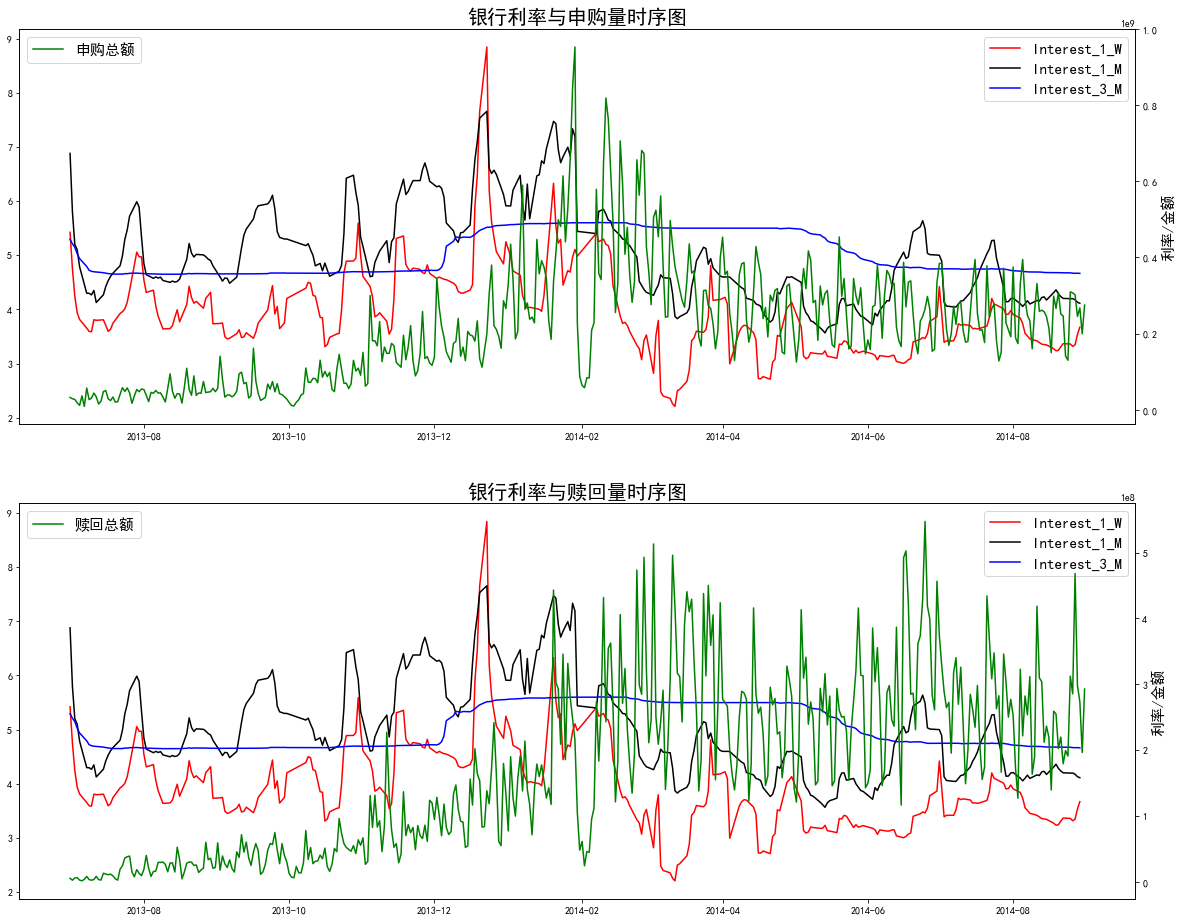

In [103]:
# 绘制双坐标图, 画出部分银行利率与交易量的时序图

fig = plt.figure(figsize=(20,16))
ax1 = plt.subplot(2, 1, 1)
plt.plot(bank['Date'], bank['Interest_1_W'], color = 'red',label="Interest_1_W")
plt.plot(bank['Date'], bank['Interest_1_M'],color = 'black',label="Interest_1_M")
plt.plot(bank['Date'], bank['Interest_3_M'], color = 'blue',label="Interest_3_M")

plt.legend(fontsize = 15)

ax2=ax1.twinx()
plt.plot(total_balance['Date'], total_balance['total_purchase_amt'],color = 'green',label="申购总额")

plt.legend(loc=2, fontsize = 15)

plt.title("银行利率与申购量时序图", fontsize = 20)
plt.xlabel("时间", fontsize = 15)
plt.ylabel("利率/金额", fontsize = 15)

ax1 = plt.subplot(2, 1, 2)
plt.plot(bank['Date'], bank['Interest_1_W'], color = 'red',label="Interest_1_W")
plt.plot(bank['Date'], bank['Interest_1_M'],color = 'black',label="Interest_1_M")
plt.plot(bank['Date'], bank['Interest_3_M'], color = 'blue',label="Interest_3_M")

plt.legend(fontsize = 15)

ax2=ax1.twinx()
plt.plot(total_balance['Date'], total_balance['total_redeem_amt'],color = 'green',label="赎回总额")

plt.legend(loc=2, fontsize = 15)

plt.title("银行利率与赎回量时序图", fontsize = 20)
plt.xlabel("时间", fontsize = 15)
plt.ylabel("利率/金额", fontsize = 15)
plt.show()

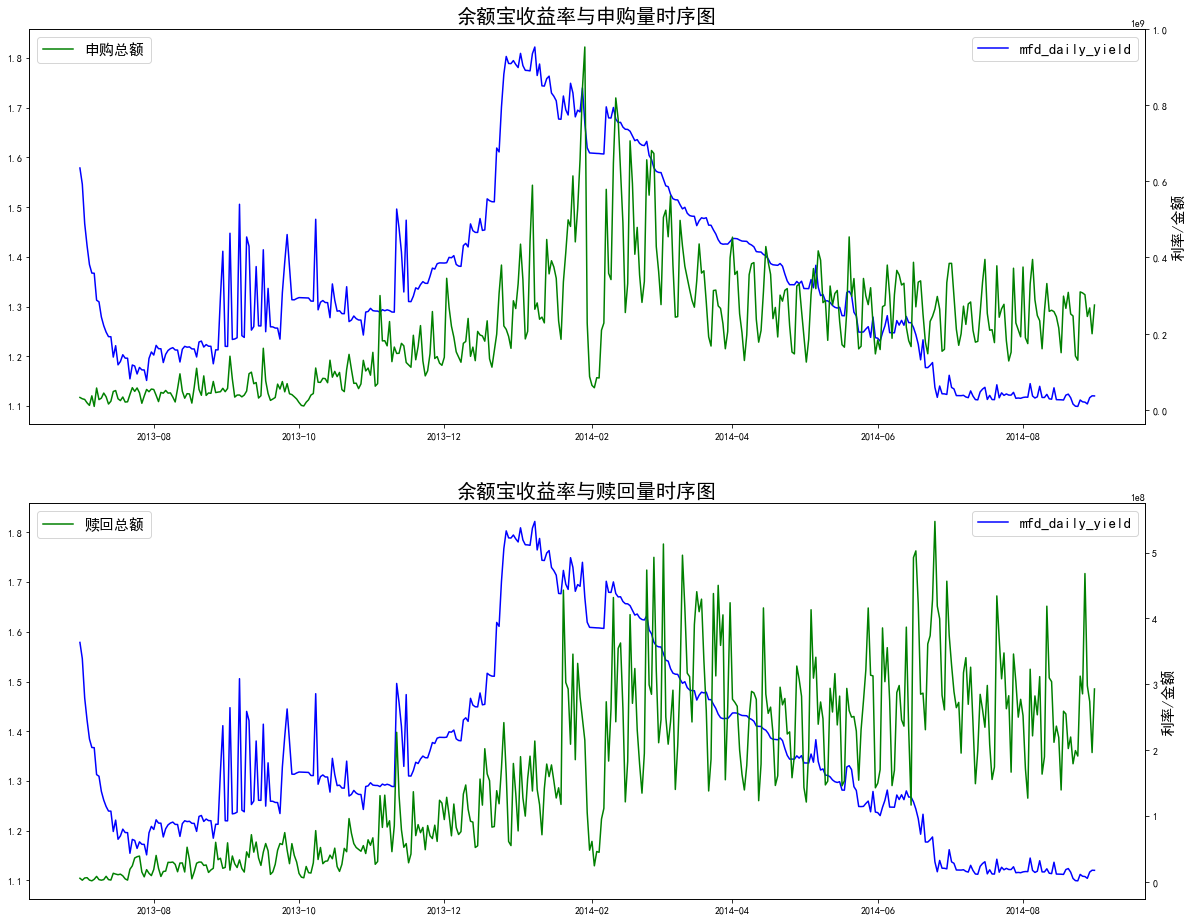

In [104]:
# 绘制双坐标图, 画出余额宝收益率与交易量的时序图

fig = plt.figure(figsize=(20,16))
ax1 = plt.subplot(2, 1, 1)
plt.plot(share['Date'], share['mfd_daily_yield'], color = 'blue',label="mfd_daily_yield")

plt.legend(fontsize = 15)

ax2=ax1.twinx()
plt.plot(total_balance['Date'], total_balance['total_purchase_amt'],color = 'green',label="申购总额")

plt.legend(loc=2, fontsize = 15)

plt.title("余额宝收益率与申购量时序图", fontsize = 20)
plt.xlabel("时间", fontsize = 15)
plt.ylabel("利率/金额", fontsize = 15)

ax1 = plt.subplot(2, 1, 2)
plt.plot(share['Date'], share['mfd_daily_yield'], color = 'blue',label="mfd_daily_yield")


plt.legend(fontsize = 15)

ax2=ax1.twinx()
plt.plot(total_balance['Date'], total_balance['total_redeem_amt'],color = 'green',label="赎回总额")

plt.legend(loc=2, fontsize = 15)

plt.title("余额宝收益率与赎回量时序图", fontsize = 20)
plt.xlabel("时间", fontsize = 15)
plt.ylabel("利率/金额", fontsize = 15)
plt.show()

## Step 10:分析用户信息

In [109]:
data_whole = pd.merge(data_balance, users, on = 'user_id')
data_whole.head()

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,...,Day,Month,Year,Week,Weekday,big_purchase,big_redeem,sex,city,constellation
0,1,20140805,20385,20383,2,0,0,0,0,0,...,5,8,2014,32,1,0,0,1,6411949,白羊座
1,1,20140808,20391,20389,2,0,0,0,0,0,...,8,8,2014,32,4,0,0,1,6411949,白羊座
2,1,20140811,20397,20395,2,0,0,0,0,0,...,11,8,2014,33,0,0,0,1,6411949,白羊座
3,1,20140814,20403,20401,2,0,0,0,0,0,...,14,8,2014,33,3,0,0,1,6411949,白羊座
4,1,20140817,20409,20407,2,0,0,0,0,0,...,17,8,2014,33,6,0,0,1,6411949,白羊座


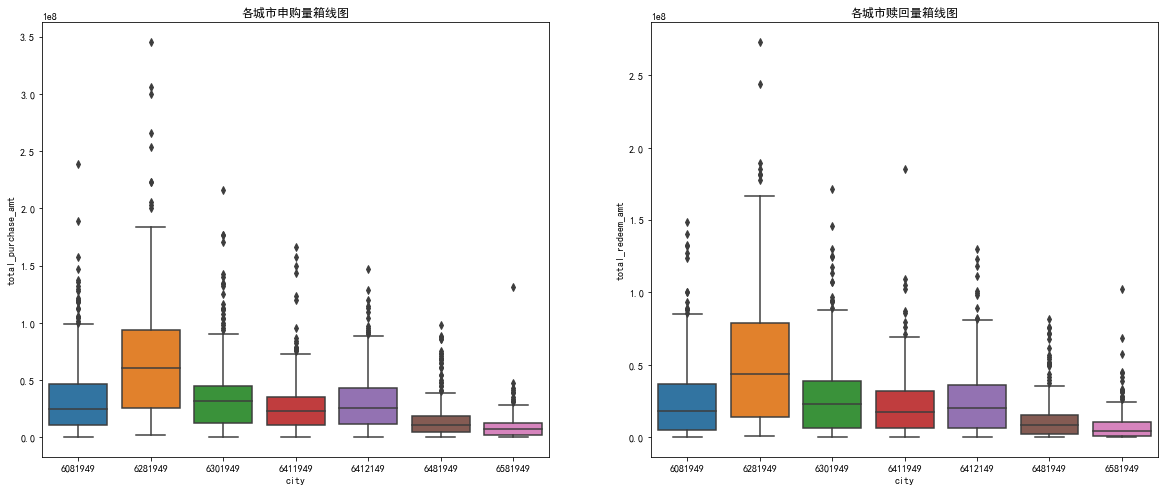

In [122]:
# 分析各个城市交易量
city_sum = data_whole[['city','Date','total_purchase_amt','total_redeem_amt']].groupby(by = ['Date','city'], as_index = False).sum()

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x = 'city', y = 'total_purchase_amt', data = city_sum)
plt.title('各城市申购量箱线图')


plt.subplot(1, 2, 2)
sns.boxplot(x = 'city', y = 'total_redeem_amt', data = city_sum)
plt.title('各城市赎回量箱线图')

plt.show()

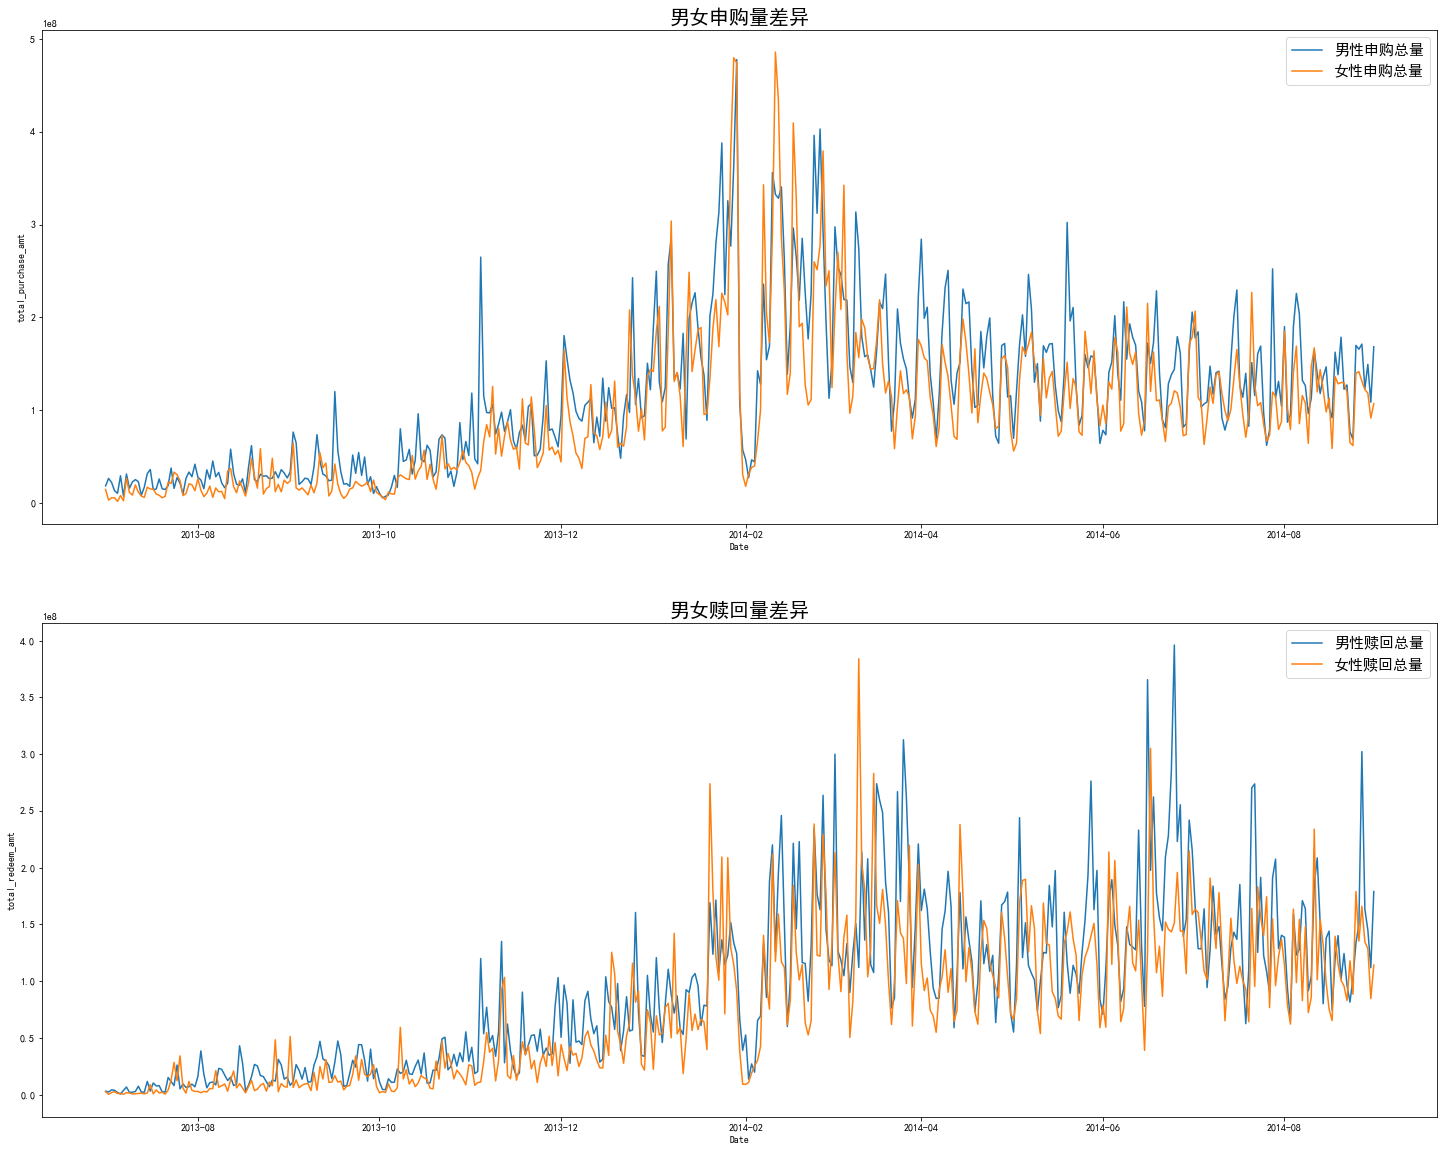

In [128]:
# 分析男女交易量差异
male_sum = data_whole[data_whole['sex'] == 1][['Date','total_purchase_amt','total_redeem_amt']].groupby(by = 'Date', as_index = False).sum()
female_sum = data_whole[data_whole['sex'] == 0][['Date','total_purchase_amt','total_redeem_amt']].groupby(by = 'Date', as_index = False).sum()

plt.figure(figsize = (25, 20))
ax = plt.subplot(2, 1, 1)
sns.lineplot(x = 'Date', y = 'total_purchase_amt', data = male_sum, label = '男性申购总量')
sns.lineplot(x = 'Date', y = 'total_purchase_amt', data = female_sum, label = '女性申购总量')

ax.set_title('男女申购量差异', fontsize = 20)
ax.legend(fontsize = 15)

ax = plt.subplot(2, 1, 2)
sns.lineplot(x = 'Date', y = 'total_redeem_amt', data = male_sum, label = '男性赎回总量')
sns.lineplot(x = 'Date', y = 'total_redeem_amt', data = female_sum, label = '女性赎回总量')

ax.set_title('男女赎回量差异', fontsize = 20)
ax.legend(fontsize = 15)

plt.show()

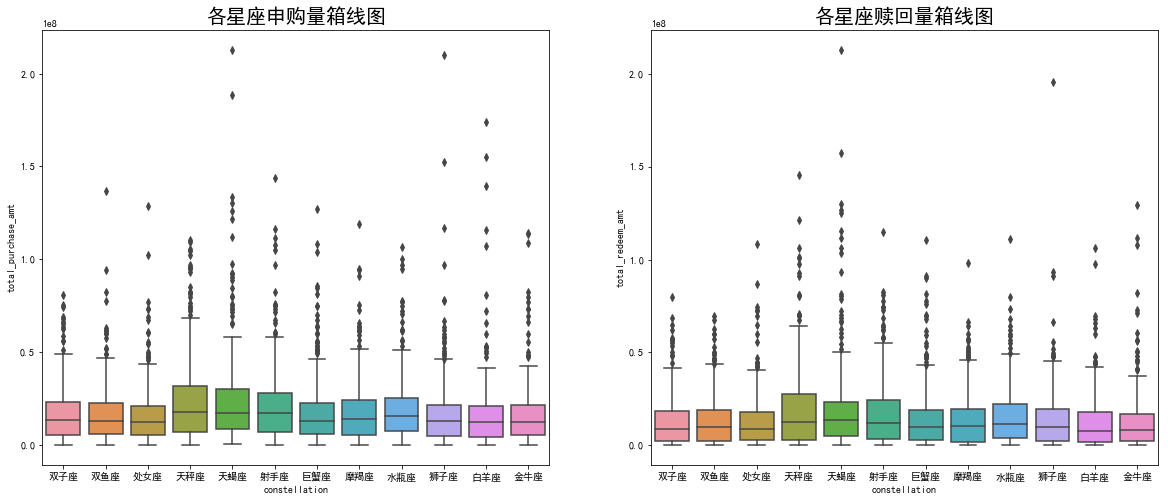

In [131]:
# 分析各个星座交易量差异
cons_sum = data_whole[['constellation','Date','total_purchase_amt','total_redeem_amt']].groupby(by = ['Date','constellation'], as_index = False).sum()

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x = 'constellation', y = 'total_purchase_amt', data = cons_sum)
plt.title('各星座申购量箱线图', fontsize = 20)


plt.subplot(1, 2, 2)
sns.boxplot(x = 'constellation', y = 'total_redeem_amt', data = cons_sum)
plt.title('各星座赎回量箱线图', fontsize = 20)

plt.show()